# Cart–Pendulum (Gymnasium + Stable-Baselines3) in a Single Notebook

This notebook contains a minimal, production-ready cart–pendulum simulation and training pipeline for Gymnasium and Stable-Baselines3.

### Highlights
- **Custom Gymnasium Environment**: `CartPendulum-v0` with RK4 integration, friction randomization, and continuous control.
- **Reproducible Training**: Uses Stable-Baselines3 SAC (`Soft Actor-Critic`).
- **Robust Scaling**: `VecNormalize` for observation scaling.
- **Simple Callbacks**: A text-based progress callback to avoid conflicts with notebook UIs.
- **All-in-One**: Installation, training, and evaluation are included.

## 1. Installation

First, we install all the required libraries. This cell will ensure that Gymnasium, Stable-Baselines3, and other dependencies are available in the Colab/Kaggle environment.

In [ ]:
!pip install --upgrade pip > /dev/null
!pip install gymnasium>=0.29.1 stable-baselines3>=2.3.0 torch>=2.2 numpy pandas matplotlib shimmy>=1.3 > /dev/null
print("✅ All libraries installed successfully!")

✅ All libraries installed successfully!


## 2. Imports and Setup

We'll import all necessary modules and set up a few environment variables to ensure compatibility with notebook environments.

In [ ]:
import os
import argparse
import math
from typing import Tuple, Union, Optional
from functools import partial

import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gymnasium.wrappers import TimeLimit
from gymnasium.envs.registration import register

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

# Avoid Rich Live display conflicts in notebooks
os.environ.setdefault("TQDM_DISABLE_RICH", "1")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


'1'

## 3. Environment Definition: `CartPendulum-v0`

Here, we define our custom Gymnasium environment. It features:
- **RK4 Integration**: A high-precision physics integrator.
- **Friction Randomization**: To train a more robust policy.
- **Curriculum Learning**: Support for starting in `swingup` or `stabilization` mode.

In [ ]:
class CartPendulumEnv(gym.Env):
    """
    Cart–Pendulum with RK4 integration and viscous friction.

    State: [theta, theta_dot, x, x_dot]
    Observation: [sin(theta), cos(theta), theta_dot, x, x_dot]
    Action: 1D force in [-10, 10]
    Termination: |x| > 2.4 (rails)
    Control dt: 0.02 s; RK4 with n_substeps per control step
    """

    metadata = {"render_modes": []}

    def __init__(
        self,
        curriculum_phase: str = "swingup",  # or "stabilization"
        c_theta: Union[float, Tuple[float, float]] = 0.0,
        c_x: Union[float, Tuple[float, float]] = 0.0,
        rk4_substeps: int = 10,
    ):
        super().__init__()
        self.dt = 0.02
        self.n_substeps = int(rk4_substeps)
        assert self.n_substeps >= 1
        self.dt_int = self.dt / self.n_substeps
        self.curriculum_phase = curriculum_phase

        # Friction config (fixed or per-episode uniform range)
        self.c_theta = c_theta
        self.c_x = c_x
        self._c_theta_ep = float(c_theta) if not hasattr(c_theta, "__len__") else None
        self._c_x_ep = float(c_x) if not hasattr(c_x, "__len__") else None

        # Spaces
        self.action_space = gym.spaces.Box(
            low=-10.0, high=10.0, shape=(1,), dtype=np.float32
        )
        obs_limit = np.array([1.0, 1.0, 15.0, 2.4, 10.0], dtype=np.float32)
        self.observation_space = gym.spaces.Box(
            low=-obs_limit, high=obs_limit, dtype=np.float32
        )

        self.state = None
        self._last_u = 0.0

    # ----- helpers -----
    def _sample_friction_for_episode(self):
        if hasattr(self.c_theta, "__len__"):
            self._c_theta_ep = float(self.np_random.uniform(self.c_theta[0], self.c_theta[1]))
        if hasattr(self.c_x, "__len__"):
            self._c_x_ep = float(self.np_random.uniform(self.c_x[0], self.c_x[1]))

    def _dyn(self, state, u: float):
        theta, theta_dot, x, x_dot = state
        c_th = self._c_theta_ep
        c_lin = self._c_x_ep
        theta_ddot = -math.sin(theta) - u * math.cos(theta) - c_th * theta_dot
        x_ddot = u - c_lin * x_dot
        return np.array([theta_dot, theta_ddot, x_dot, x_ddot], dtype=np.float64)

    def _rk4_step(self, state, u: float):
        for _ in range(self.n_substeps):
            k1 = self._dyn(state, u)
            k2 = self._dyn(state + 0.5 * self.dt_int * k1, u)
            k3 = self._dyn(state + 0.5 * self.dt_int * k2, u)
            k4 = self._dyn(state + self.dt_int * k3, u)
            state = state + (self.dt_int / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        return state

    def _get_obs(self):
        theta, theta_dot, x, x_dot = self.state
        return np.array(
            [math.sin(theta), math.cos(theta), theta_dot, x, x_dot], dtype=np.float32
        )

    def _compute_reward(self, u, du):
        theta, theta_dot, x, _ = self.state
        reward = math.cos(theta) - 1.0
        reward -= 0.1 * x**2 + 0.05 * theta_dot**2 + 0.01 * (u**2) + 1e-4 * (du**2)
        if abs(theta) < 0.2 and abs(x) < 0.2:
            reward += 10.0
        return reward

    # ----- Gymnasium API -----
    def reset(self, seed: Optional[int] = None, options=None):
        super().reset(seed=seed)
        self._sample_friction_for_episode()

        if self.curriculum_phase == "stabilization":
            self.state = self.np_random.uniform(low=-0.1, high=0.1, size=(4,)).astype(np.float64)
        else:
            self.state = np.array(
                [
                    self.np_random.uniform(low=math.pi - 0.2, high=math.pi + 0.2),
                    self.np_random.uniform(low=-0.5, high=0.5),
                    self.np_random.uniform(low=-0.2, high=0.2),
                    self.np_random.uniform(low=-0.2, high=0.2),
                ],
                dtype=np.float64,
            )

        self._last_u = 0.0
        return self._get_obs(), {}

    def step(self, action):
        a = np.asarray(action, dtype=np.float32)
        u = float(np.clip(a.reshape(-1)[0] if a.ndim > 0 else a, -10.0, 10.0))
        du = u - self._last_u
        self._last_u = u

        self.state = self._rk4_step(self.state, u)
        # Wrap theta to [-pi, pi]
        self.state[0] = ((self.state[0] + math.pi) % (2 * math.pi)) - math.pi

        reward = self._compute_reward(u, du)
        terminated = abs(self.state[2]) > 2.4  # rail hit
        truncated = False  # use TimeLimit wrapper outside
        return self._get_obs(), reward, terminated, truncated, {}


# Register the environment with Gymnasium so we can create it by ID
register(
    id="CartPendulum-v0",
    entry_point=__name__ + ":CartPendulumEnv",
)
print("✅ Environment 'CartPendulum-v0' registered successfully!")

✅ Environment 'CartPendulum-v0' registered successfully!


## 4. Training Script Logic

This section contains the logic for training the SAC agent. We define a simple callback for progress updates and a main training function.

In [ ]:
# ---------- Simple text progress callback ----------
class TextProgressCallback(BaseCallback):
    def __init__(self, total_timesteps: int, update_every: int = 10_000, name: str = "train"):
        super().__init__()
        self.total = int(total_timesteps)
        self.update_every = int(update_every)
        self.name = name
        self._last_n = 0

    def _on_step(self) -> bool:
        n = self.num_timesteps
        if n - self._last_n >= self.update_every or n >= self.total:
            pct = 100.0 * n / max(1, self.total)
            print(f"[{self.name}] Timesteps: {n}/{self.total} ({pct:5.1f}%)", flush=True)
            self._last_n = n
        return True

def train_model(total_steps, n_envs, train_substeps, batch_size, gradient_steps, seed, device):
    """Main function to orchestrate the training process."""
    train_kwargs = dict(
        curriculum_phase="swingup",
        rk4_substeps=train_substeps,
        c_theta=(0.0, 0.05),
        c_x=(0.0, 0.08),
    )

    # Use a partial function to pass arguments to the TimeLimit wrapper
    wrapper_kwargs = {'max_episode_steps': 1000}
    wrapper = partial(TimeLimit, **wrapper_kwargs)

    # Create the vectorized environment
    env = make_vec_env(
        env_id="CartPendulum-v0",
        n_envs=n_envs,
        seed=seed,
        vec_env_cls=DummyVecEnv,
        env_kwargs=train_kwargs,
        wrapper_class=wrapper,
    )
    env = VecNormalize(env, norm_obs=True, norm_reward=False)

    sac_params = dict(
        learning_rate=3e-4,
        buffer_size=int(1e6),
        batch_size=batch_size,
        gamma=0.99,
        tau=0.005,
        train_freq=(1, "step"),
        gradient_steps=gradient_steps,
        ent_coef="auto_0.1",
        policy_kwargs=dict(net_arch=[256, 256]),
        verbose=0,  # Use our custom callback for progress
        device=device,
        seed=seed,
    )

    model = SAC("MlpPolicy", env, **sac_params)
    cb = TextProgressCallback(total_timesteps=total_steps, update_every=50_000, name="SAC-CartPendulum")

    save_dir = "runs/sac_cartpendulum"
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "sac_model.zip")
    vecnorm_path = os.path.join(save_dir, "vecnormalize.pkl")

    print(f"\nStarting training for {total_steps} timesteps...")
    model.learn(total_timesteps=total_steps, progress_bar=True, callback=cb)

    model.save(model_path)
    env.save(vecnorm_path)
    print(f"\nTraining complete. Saved model to {model_path} and stats to {vecnorm_path}", flush=True)

    return model_path, vecnorm_path

## 5. Evaluation Script Logic

This section contains the logic for evaluating a trained policy. It loads a model and `VecNormalize` statistics, runs several episodes, and prints a summary of the performance. It also includes a function to plot the results.

In [ ]:
def make_eval_env(env_id: str, env_kwargs: dict, max_steps: int = 1000):
    def _thunk():
        env = gym.make(env_id, **env_kwargs)
        return TimeLimit(env, max_episode_steps=max_steps)
    return _thunk

def run_episode(model: SAC, vec_env: VecNormalize, max_seconds=20.0):
    obs = vec_env.reset()
    dt = vec_env.get_attr("dt")[0]
    t = 0.0

    history = {k: [] for k in ['time', 'theta', 'x', 'action', 'reward']}

    done = False
    while t < max_seconds and not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = vec_env.step(action)

        # Get the true, unnormalized state from the environment
        state = vec_env.get_attr("state")[0]
        history['time'].append(t)
        history['theta'].append(state[0])
        history['x'].append(state[2])
        history['action'].append(action[0][0])
        history['reward'].append(rewards[0])

        done = bool(dones[0])
        t += dt

    return pd.DataFrame(history)

def plot_episode(df: pd.DataFrame, episode_num: int):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Evaluation: Episode {episode_num}", fontsize=16)

    axes[0, 0].plot(df['time'], np.rad2deg(df['theta']), lw=2)
    axes[0, 0].set_title("Pole Angle (deg)")
    axes[0, 0].axhline(0, c='k', ls='--', alpha=0.5)

    axes[0, 1].plot(df['time'], df['x'], lw=2)
    axes[0, 1].set_title("Cart Position (m)")
    axes[0, 1].axhline(0, c='k', ls='--', alpha=0.5)

    axes[1, 0].plot(df['time'], df['action'], lw=2)
    axes[1, 0].set_title("Control Action (N)")
    axes[1, 0].set_xlabel("Time (s)")

    axes[1, 1].plot(df['time'], df['reward'].cumsum(), lw=2)
    axes[1, 1].set_title("Cumulative Reward")
    axes[1, 1].set_xlabel("Time (s)")

    for ax in axes.flat:
        ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def evaluate_model(model_path, vecnorm_path, episodes, c_theta, c_x, eval_substeps, plot):
    """Main function to orchestrate the evaluation process."""
    env_kwargs = dict(
        curriculum_phase="swingup",
        rk4_substeps=eval_substeps,
        c_theta=c_theta,
        c_x=c_x,
    )

    # Build a single-environment VecEnv for evaluation
    dummy_env = DummyVecEnv([make_eval_env("CartPendulum-v0", env_kwargs)])
    vec_env = VecNormalize.load(vecnorm_path, dummy_env)
    vec_env.training = False
    vec_env.norm_reward = False

    model = SAC.load(model_path, env=vec_env, device="cpu")

    all_steps = []
    all_rewards = []
    print(f"\nStarting evaluation for {episodes} episodes...")
    for ep in range(episodes):
        df = run_episode(model, vec_env)
        steps = len(df)
        cum_rew = df['reward'].sum()
        all_steps.append(steps)
        all_rewards.append(cum_rew)
        print(f"Episode {ep+1}: Steps={steps}, CumReward={cum_rew:.2f}")
        if plot:
            plot_episode(df, ep + 1)

    steps_arr = np.array(all_steps)
    rewards_arr = np.array(all_rewards)
    print("\n--- Summary ---")
    print(f"Mean Steps:  {steps_arr.mean():.1f} +/- {steps_arr.std():.1f}")
    print(f"Mean Reward: {rewards_arr.mean():.2f} +/- {rewards_arr.std():.2f}")

## 6. Run Training and Evaluation

This is the main execution block. You can configure all the training and evaluation parameters here, then run the cells to train a new model and see how it performs.

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:728: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(



Starting training for 1500000 timesteps...


[SAC-CartPendulum] Timesteps: 50000/1500000 (  3.3%)

[SAC-CartPendulum] Timesteps: 100000/1500000 (  6.7%)

[SAC-CartPendulum] Timesteps: 150000/1500000 ( 10.0%)

[SAC-CartPendulum] Timesteps: 200000/1500000 ( 13.3%)

[SAC-CartPendulum] Timesteps: 250000/1500000 ( 16.7%)

[SAC-CartPendulum] Timesteps: 300000/1500000 ( 20.0%)

[SAC-CartPendulum] Timesteps: 350000/1500000 ( 23.3%)

[SAC-CartPendulum] Timesteps: 400000/1500000 ( 26.7%)

[SAC-CartPendulum] Timesteps: 450000/1500000 ( 30.0%)

[SAC-CartPendulum] Timesteps: 500000/1500000 ( 33.3%)

[SAC-CartPendulum] Timesteps: 550000/1500000 ( 36.7%)

[SAC-CartPendulum] Timesteps: 600000/1500000 ( 40.0%)

[SAC-CartPendulum] Timesteps: 650000/1500000 ( 43.3%)

[SAC-CartPendulum] Timesteps: 700000/1500000 ( 46.7%)

[SAC-CartPendulum] Timesteps: 750000/1500000 ( 50.0%)

[SAC-CartPendulum] Timesteps: 800000/1500000 ( 53.3%)

[SAC-CartPendulum] Timesteps: 850000/1500000 ( 56.7%)

[SAC-CartPendulum] Timesteps: 900000/1500000 ( 60.0%)

[SAC-CartPendulum] Timesteps: 950000/1500000 ( 63.3%)

[SAC-CartPendulum] Timesteps: 1000000/1500000 ( 66.7%)

[SAC-CartPendulum] Timesteps: 1050000/1500000 ( 70.0%)

[SAC-CartPendulum] Timesteps: 1100000/1500000 ( 73.3%)

[SAC-CartPendulum] Timesteps: 1150000/1500000 ( 76.7%)

[SAC-CartPendulum] Timesteps: 1200000/1500000 ( 80.0%)

[SAC-CartPendulum] Timesteps: 1250000/1500000 ( 83.3%)

[SAC-CartPendulum] Timesteps: 1300000/1500000 ( 86.7%)

[SAC-CartPendulum] Timesteps: 1350000/1500000 ( 90.0%)

[SAC-CartPendulum] Timesteps: 1400000/1500000 ( 93.3%)

[SAC-CartPendulum] Timesteps: 1450000/1500000 ( 96.7%)

[SAC-CartPendulum] Timesteps: 1500000/1500000 (100.0%)


Training complete. Saved model to runs/sac_cartpendulum/sac_model.zip and stats to runs/sac_cartpendulum/vecnormalize.pkl

Starting evaluation for 5 episodes...
Episode 1: Steps=1000, CumReward=7973.46


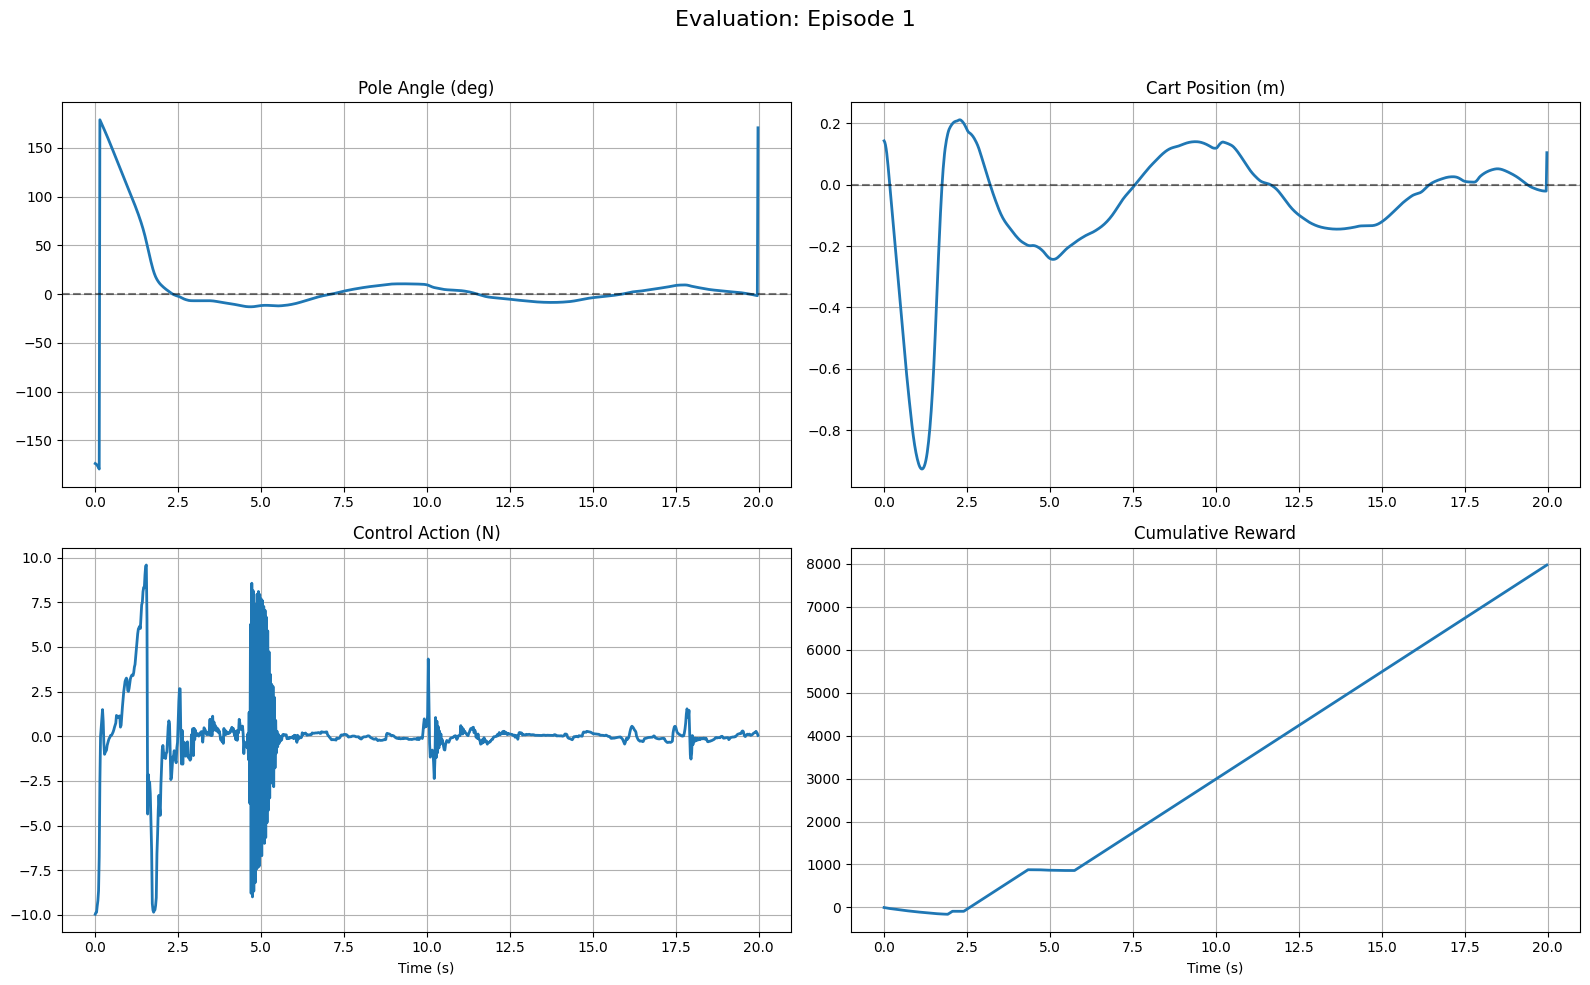

Episode 2: Steps=1000, CumReward=7898.16


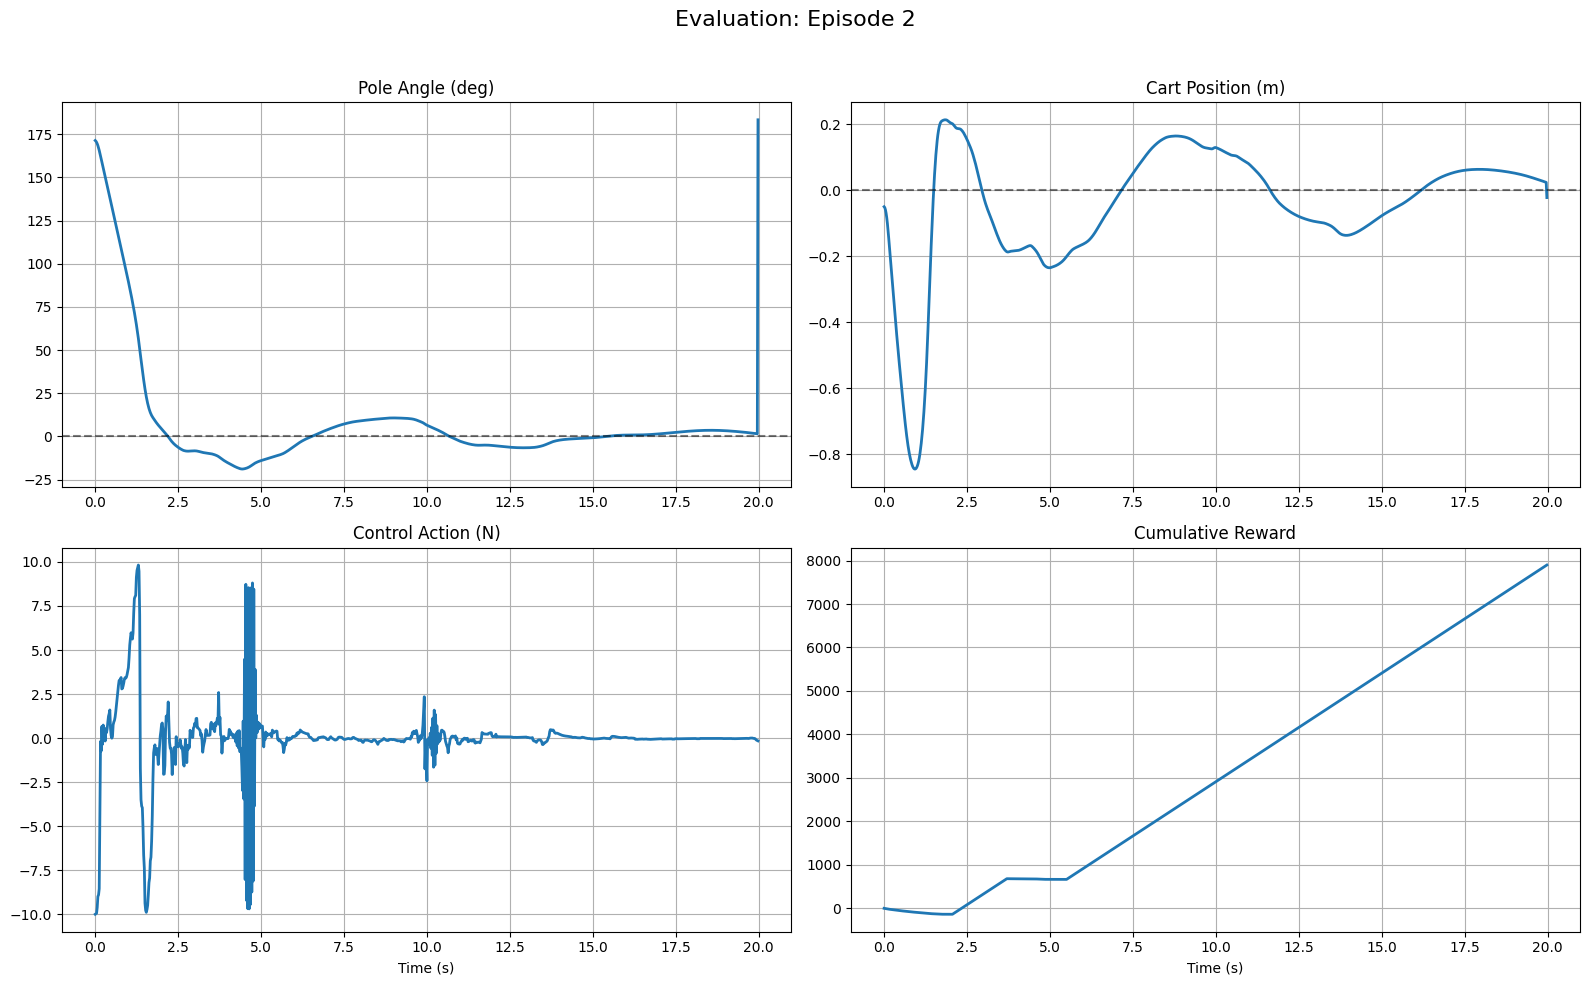

Episode 3: Steps=1000, CumReward=6442.01


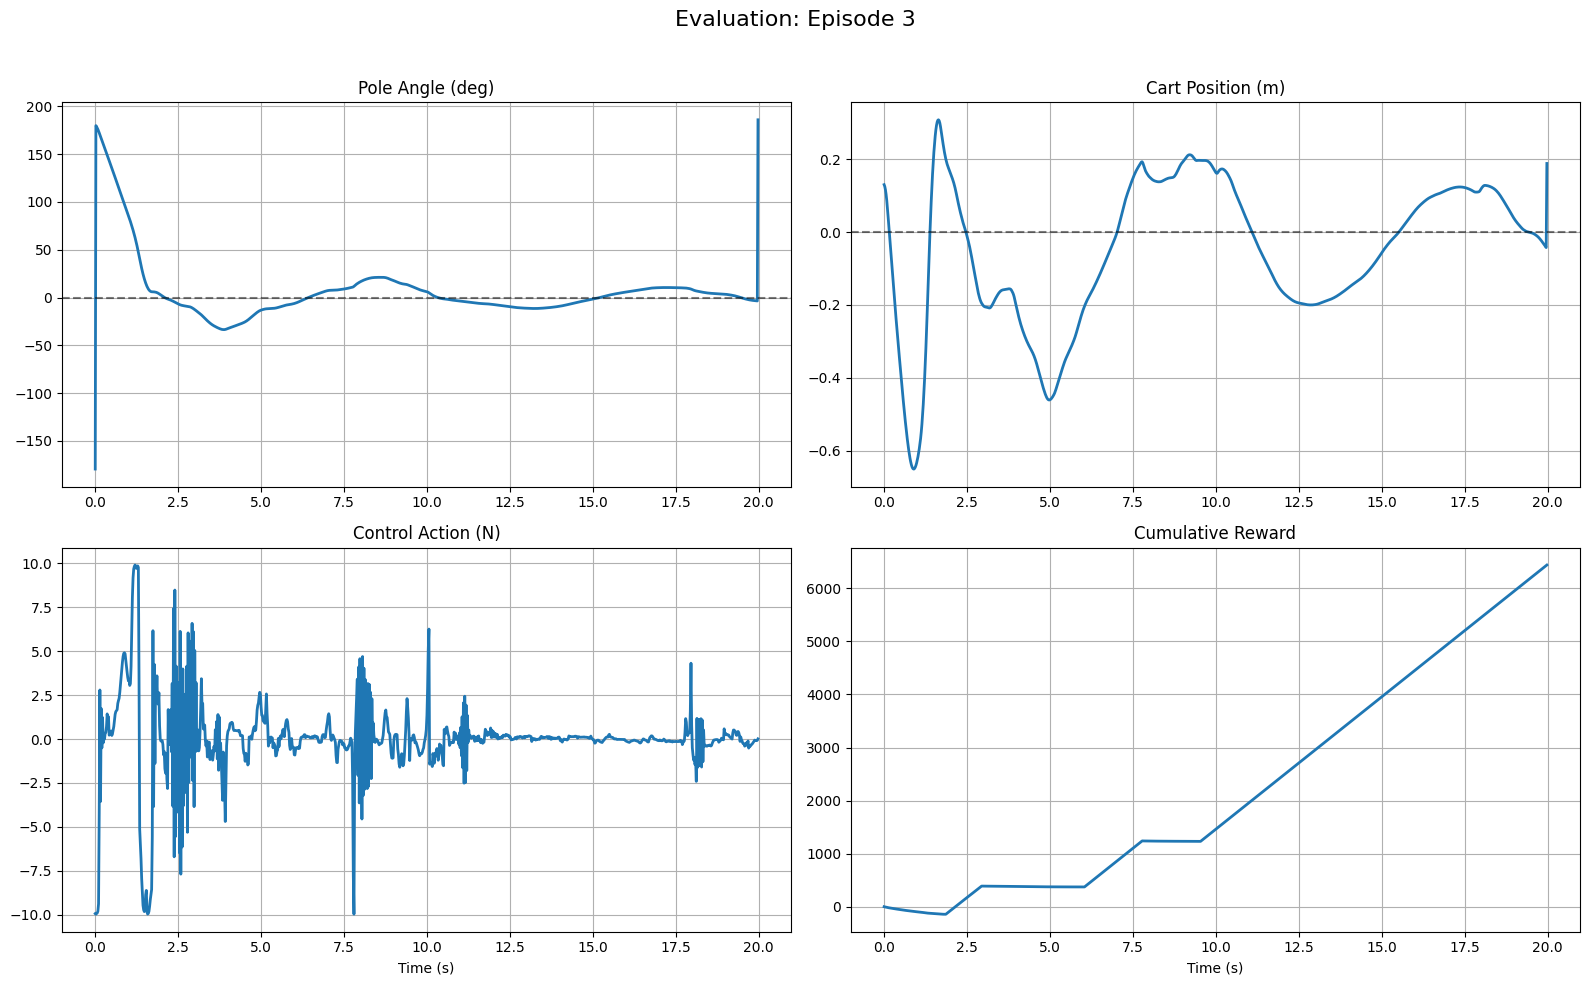

Episode 4: Steps=1000, CumReward=8851.52


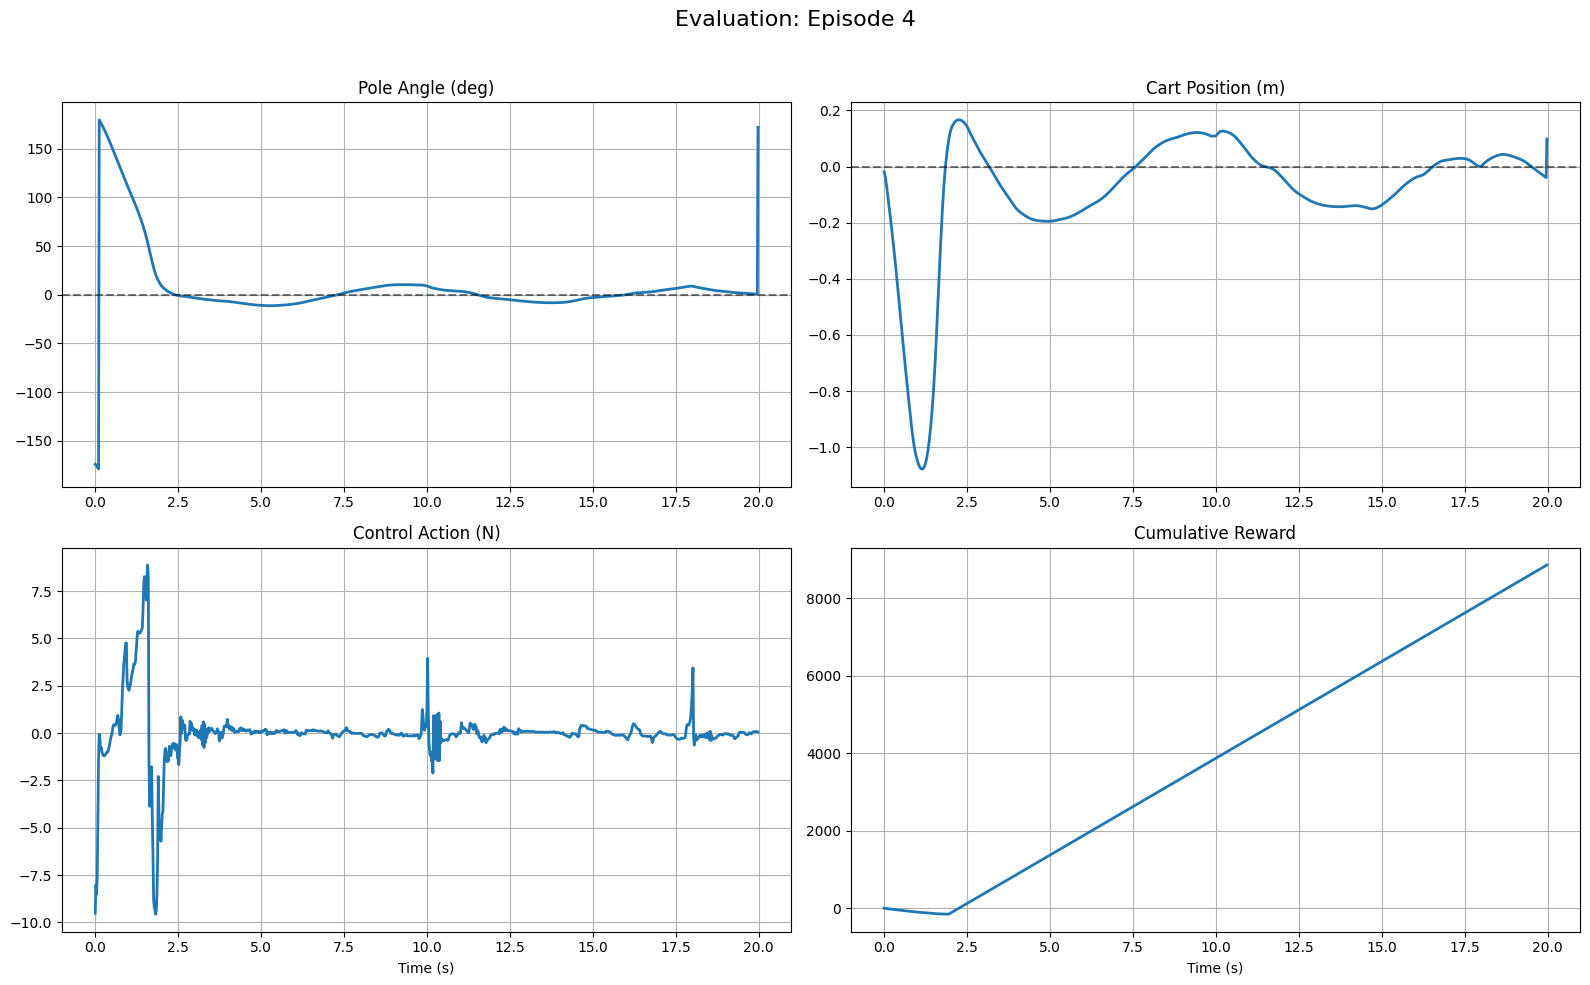

Episode 5: Steps=1000, CumReward=8544.74


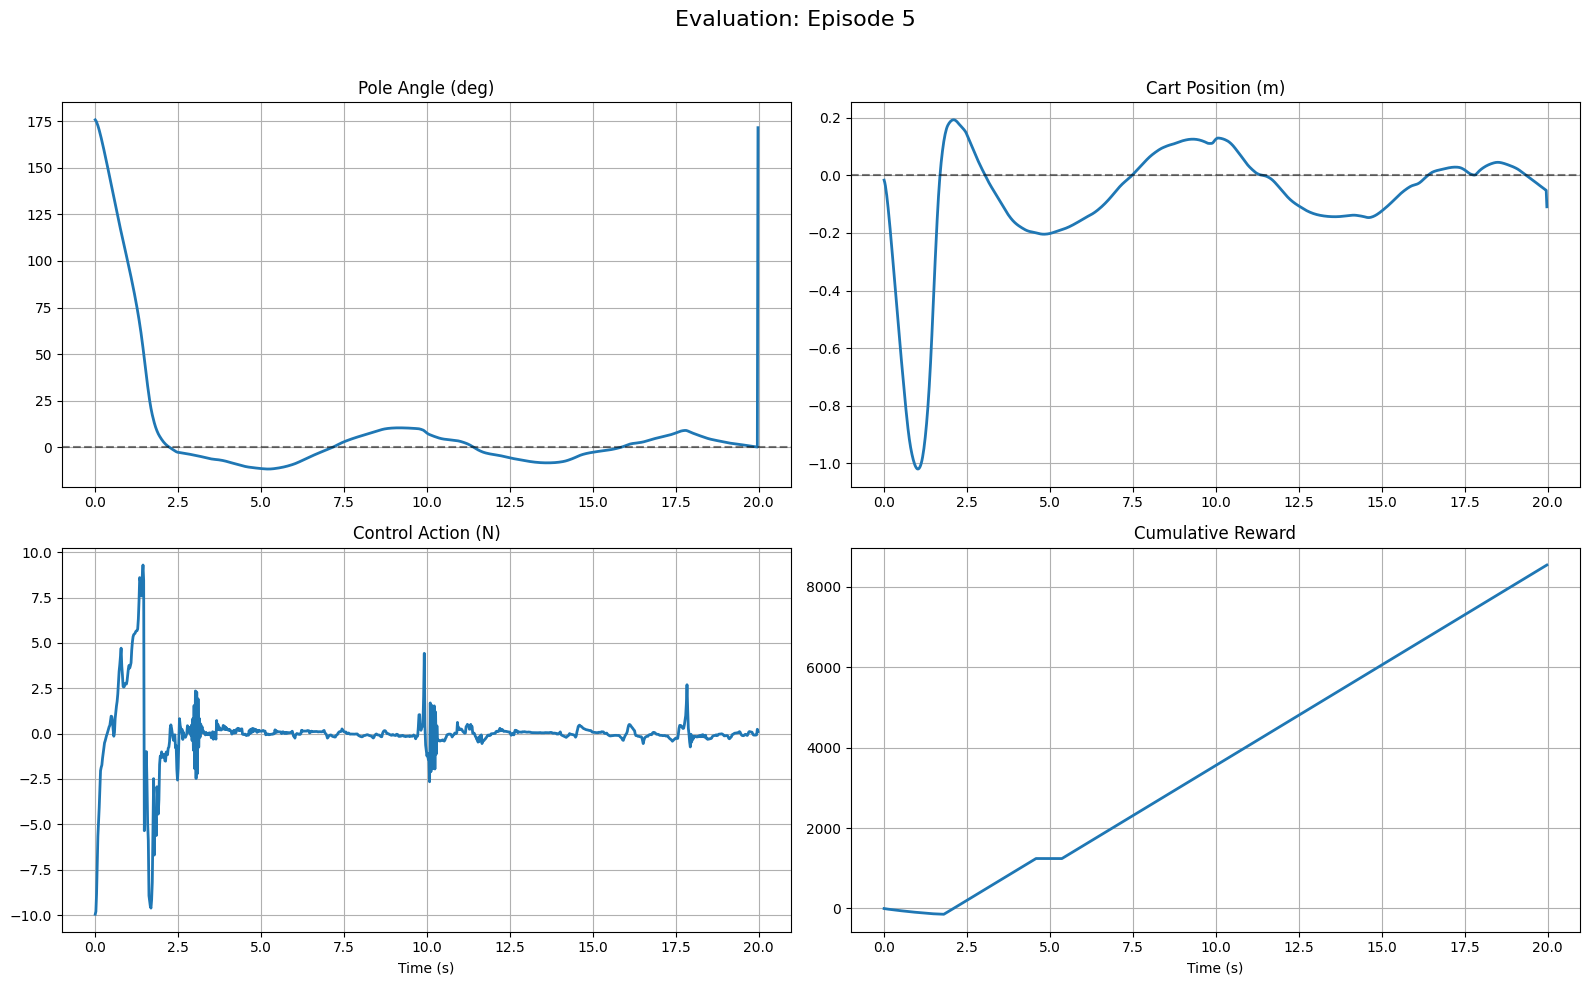


--- Summary ---
Mean Steps:  1000.0 +/- 0.0
Mean Reward: 7941.98 +/- 829.87


In [ ]:
# --- Configuration ---
TRAIN_CONFIG = {
    "total_steps": 1_500_000, # Set to a lower value like 100k for a quick test
    "n_envs": 8,
    "train_substeps": 6,
    "batch_size": 768,
    "gradient_steps": 3,
    "seed": 42,
    "device": "cuda"
}

EVAL_CONFIG = {
    "episodes": 5,
    "c_theta": 0.02,
    "c_x": 0.05,
    "eval_substeps": 10,
    "plot": True, # Set to True to see plots of the evaluation episodes
}

# --- Run Training ---
model_path, vecnorm_path = train_model(**TRAIN_CONFIG)

# --- Run Evaluation ---
evaluate_model(
    model_path=model_path,
    vecnorm_path=vecnorm_path,
    **EVAL_CONFIG
)

In [ ]:
#!/usr/bin/env python3
"""
Cart–Pendulum Comparative Control Study (RK4 Everywhere, with Fine-Tuning)
- This script is now robust for both command-line and notebook execution.
"""

from __future__ import annotations
import os
import time
import math
import argparse
import sys
from functools import partial
from typing import Tuple, Union, Optional, Dict, Any, List

os.environ.setdefault("OMP_NUM_THREADS", "1"); os.environ.setdefault("MKL_NUM_THREADS", "1"); os.environ.setdefault("TQDM_DISABLE_RICH", "1")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from scipy.integrate import solve_bvp, solve_ivp
from scipy.linalg import solve_continuous_are

torch.set_num_threads(1)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 10); plt.rcParams['font.size'] = 12

# =========================
# Environment Definition
# =========================
class CartPendulumEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, curriculum_phase: str = "swingup", c_theta: Union[float, Tuple[float, float]] = 0.0,
                 c_x: Union[float, Tuple[float, float]] = 0.0, rk4_substeps: int = 10,
                 soft_wall_start: float = 1.8, soft_wall_k: float = 0.0, du_weight: float = 1e-4,
                 seed: Optional[int] = None, stabilization_prob: float = 0.0):
        super().__init__()
        self.dt = 0.02; self.n_substeps = int(rk4_substeps); self.dt_int = self.dt / self.n_substeps
        self.curriculum_phase = curriculum_phase; self.c_theta = c_theta; self.c_x = c_x
        self._c_theta_ep = float(c_theta) if not hasattr(c_theta, "__len__") else None
        self._c_x_ep = float(c_x) if not hasattr(c_x, "__len__") else None
        self.soft_wall_start = float(soft_wall_start); self.soft_wall_k = float(soft_wall_k)
        self.du_weight = float(du_weight); self.stabilization_prob = float(stabilization_prob)
        self.action_space = gym.spaces.Box(low=-10.0, high=10.0, shape=(1,), dtype=np.float32)
        obs_limit = np.array([1.0, 1.0, 15.0, 2.4, 10.0], dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-obs_limit, high=obs_limit, dtype=np.float32)
        self.state = None; self._last_u = 0.0
        if seed is not None: self.reset(seed=seed)
    def _sample_friction_for_episode(self):
        if hasattr(self.c_theta, "__len__"): self._c_theta_ep = float(self.np_random.uniform(self.c_theta[0], self.c_theta[1]))
        if hasattr(self.c_x, "__len__"): self._c_x_ep = float(self.np_random.uniform(self.c_x[0], self.c_x[1]))
    def _dyn(self, state, u: float):
        theta, theta_dot, x, x_dot = state
        c_th = self._c_theta_ep if self._c_theta_ep is not None else float(self.c_theta)
        c_lin = self._c_x_ep if self._c_x_ep is not None else float(self.c_x)
        theta_ddot = -math.sin(theta) - u * math.cos(theta) - c_th * theta_dot
        x_ddot = u - c_lin * x_dot
        return np.array([theta_dot, theta_ddot, x_dot, x_ddot], dtype=np.float64)
    def _rk4_step(self, state, u: float):
        for _ in range(self.n_substeps):
            k1=self._dyn(state, u); k2=self._dyn(state + 0.5*self.dt_int*k1, u)
            k3=self._dyn(state + 0.5*self.dt_int*k2, u); k4=self._dyn(state + self.dt_int*k3, u)
            state = state + (self.dt_int/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return state
    def _get_obs(self):
        theta, theta_dot, x, x_dot = self.state
        return np.array([math.sin(theta), math.cos(theta), theta_dot, x, x_dot], dtype=np.float32)
    def _compute_reward(self, u, du):
        theta, theta_dot, x, _ = self.state; reward = math.cos(theta) - 1.0
        reward -= 0.15*x**2 + 0.05*theta_dot**2 + 0.01*(u**2) + self.du_weight*(du**2)
        if self.soft_wall_k > 0.0: wall = max(abs(x) - self.soft_wall_start, 0.0); reward -= self.soft_wall_k * (wall**2)
        if abs(theta) < 0.2 and abs(x) < 0.2: reward += 10.0
        return reward
    def reset(self, seed: Optional[int] = None, options=None):
        super().reset(seed=seed); self._sample_friction_for_episode()
        use_stabilization_start = self.curriculum_phase=="stabilization" or (self.curriculum_phase=="swingup" and self.np_random.random()<self.stabilization_prob)
        if use_stabilization_start:
            self.state = self.np_random.uniform(low=-0.1, high=0.1, size=(4,)).astype(np.float64)
        else:
            self.state = np.array([self.np_random.uniform(low=math.pi-0.2, high=math.pi+0.2), self.np_random.uniform(low=-0.5, high=0.5), self.np_random.uniform(low=-0.2, high=0.2), self.np_random.uniform(low=-0.2, high=0.2)], dtype=np.float64)
        self._last_u = 0.0; return self._get_obs(), {}
    def step(self, action):
        a = np.asarray(action, dtype=np.float32); u = float(np.clip(a.reshape(-1)[0] if a.ndim > 0 else a, -10.0, 10.0))
        du = u - self._last_u; self._last_u = u
        self.state = self._rk4_step(self.state, u)
        self.state[0] = ((self.state[0] + math.pi) % (2 * math.pi)) - math.pi
        reward = self._compute_reward(u, du); terminated = abs(self.state[2]) > 2.4
        return self._get_obs(), reward, terminated, False, {}

# =========================
# Callbacks and Training
# =========================
class TextProgressCallback(BaseCallback):
    def __init__(self, total_timesteps: int, update_every: int = 50_000, name: str = "train"):
        super().__init__(); self.total=int(total_timesteps); self.update_every=int(update_every); self.name=name; self._last_n=0; self._last_t=None
    def _on_training_start(self) -> None: self._last_t=time.time()
    def _on_step(self) -> bool:
        n=self.num_timesteps
        if n-self._last_n>=self.update_every or n>=self.total:
            now=time.time(); dt=max(1e-6,now-(self._last_t or now)); fps=(n-self._last_n)/dt
            print(f"[{self.name}] {n}/{self.total} ({100.0*n/max(1,self.total):5.1f}%)  ~{fps:,.0f} steps/s", flush=True)
            self._last_n=n; self._last_t=now
        return True

def train_or_finetune_sac(**kwargs):
    """
    Robust train/finetune:
    - Finetune loads the prior Phase-2 VecNormalize (no fresh stats)
    - learning_starts = 0 for finetune
    - reset_num_timesteps = False for finetune
    - env_p2.norm_reward=False, env_p2.training=True
    - Optional LR cooling for finetune
    """
    out_dir = kwargs['out_dir']; os.makedirs(out_dir, exist_ok=True)
    is_finetune = kwargs.get('is_finetune', False)
    n_envs = kwargs['n_envs']; seed = kwargs['seed']; device = kwargs['device']

    start_method = {"start_method": "spawn" if "ipykernel" in sys.modules else "fork"} if os.name == "posix" else {}

    # Phase 1 (only when training from scratch)
    if not is_finetune:
        p1_out_dir = os.path.join(out_dir, "phase1"); os.makedirs(p1_out_dir, exist_ok=True)
        p1_model_path = os.path.join(p1_out_dir, "sac_stabilize_model.zip")
        p1_vecnorm_path = os.path.join(p1_out_dir, "vecnormalize_stabilize.pkl")
        print("\n--- Starting Training: Phase 1 (Stabilization) ---")

        def make_p1_env():
            return TimeLimit(
                CartPendulumEnv(curriculum_phase="stabilization",
                                rk4_substeps=kwargs['train_substeps'],
                                c_theta=(0.0, 0.03), c_x=(0.0, 0.05)),
                max_episode_steps=500
            )

        env_p1 = make_vec_env(make_p1_env, n_envs=n_envs, seed=seed,
                              vec_env_cls=SubprocVecEnv if n_envs > 1 else DummyVecEnv,
                              vec_env_kwargs=start_method)
        env_p1 = VecNormalize(env_p1, norm_obs=True, norm_reward=True)

        p1_params = dict(
            learning_rate=3e-4, buffer_size=int(1e6), batch_size=1024,
            gamma=0.99, tau=0.005, train_freq=(64, "step"), gradient_steps=64,
            learning_starts=10_000, ent_coef='auto_0.1',
            policy_kwargs=dict(net_arch=[256, 256]),
            verbose=0, device=device, seed=seed
        )
        model_p1 = SAC("MlpPolicy", env_p1, **p1_params)
        model_p1.learn(total_timesteps=75_000, progress_bar=False,
                       callback=TextProgressCallback(75_000, 10_000, "Phase1"))
        model_p1.save(p1_model_path); env_p1.save(p1_vecnorm_path)
        print(f"--- Phase 1 Complete ---\nModel saved to {p1_model_path}")
        pretrained_model_path = p1_model_path
        pretrained_vecnorm_path = p1_vecnorm_path  # not used in p2; just for clarity
    else:
        print("\n--- Starting Fine-Tuning Session ---")
        pretrained_model_path = kwargs['model']
        # IMPORTANT: this must be the Phase-2 vecnorm from the model you are fine-tuning
        pretrained_vecnorm_path = kwargs['vecnorm']

    # Phase 2 env (swing-up with optional upright starts)
    def make_p2_env():
        return TimeLimit(
            CartPendulumEnv(
                curriculum_phase="swingup",
                rk4_substeps=kwargs['train_substeps'],
                c_theta=(0.0, 0.05), c_x=(0.0, 0.08),
                soft_wall_start=1.8, soft_wall_k=kwargs['soft_wall_k'],
                du_weight=kwargs['du_weight'],
                stabilization_prob=kwargs.get('stabilization_prob', 0.2)  # default 20% upright starts
            ),
            max_episode_steps=1000
        )

    base_p2 = make_vec_env(make_p2_env, n_envs=n_envs, seed=seed,
                           vec_env_cls=SubprocVecEnv if n_envs > 1 else DummyVecEnv,
                           vec_env_kwargs=start_method)

    if is_finetune:
        # Load Phase-2 VecNormalize from the same run as the pretrained model
        env_p2 = VecNormalize.load(pretrained_vecnorm_path, base_p2)
        env_p2.training = True
        env_p2.norm_reward = False
    else:
        env_p2 = VecNormalize(base_p2, norm_obs=True, norm_reward=False)

    # SAC params (only used when training from scratch)
    sac_params = dict(
        learning_rate=kwargs.get('learning_rate', 3e-4),
        buffer_size=int(1e6),
        batch_size=kwargs['batch_size'],
        gamma=0.99, tau=0.005,
        train_freq=(64, "step"),
        gradient_steps=kwargs['gradient_steps'],
        learning_starts=0 if is_finetune else 10_000,   # FINETUNE: start learning immediately
        ent_coef=kwargs['ent_coef'],
        policy_kwargs=dict(net_arch=[256, 256], use_sde=False),
        verbose=0, device=device, seed=seed
    )

    if is_finetune:
        # Load the whole model; sac_params are ignored by load
        model_p2 = SAC.load(pretrained_model_path, env=env_p2, device=device)

        # Make sure fine-tune updates begin immediately
        model_p2.learning_starts = 0

        # Cool the LR for BOTH optimizers (actor and critic)
        finetune_lr = kwargs.get('finetune_lr', 1e-4)
        try:
            for pg in model_p2.actor.optimizer.param_groups:
                pg['lr'] = finetune_lr
            for pg in model_p2.critic.optimizer.param_groups:
                pg['lr'] = finetune_lr
        except AttributeError:
            # Fallback: access through policy
            for pg in model_p2.policy.actor.optimizer.param_groups:
                pg['lr'] = finetune_lr
            for pg in model_p2.policy.critic.optimizer.param_groups:
                pg['lr'] = finetune_lr

        # Optionally cool entropy target and its optimizer LR
        if kwargs.get('target_entropy') is not None:
            model_p2.target_entropy = kwargs['target_entropy']  # e.g., -0.7 for 1D action
        if getattr(model_p2, "ent_coef_optimizer", None) is not None:
            for pg in model_p2.ent_coef_optimizer.param_groups:
                pg['lr'] *= 0.5

        # Optionally load replay to preserve data distribution
        if kwargs.get('replay_buffer') and os.path.exists(kwargs['replay_buffer']):
            model_p2.load_replay_buffer(kwargs['replay_buffer'])
    else:
        model_p2 = SAC("MlpPolicy", env_p2, **sac_params)
        # Transfer full policy from Phase 1
        pretrained_policy = SAC.load(pretrained_model_path, device=device).policy
        model_p2.policy.load_state_dict(pretrained_policy.state_dict(), strict=False)
        print("Transferred full policy from Phase 1 model.")

    final_model_path = os.path.join(out_dir, "sac_model.zip")
    final_vecnorm_path = os.path.join(out_dir, "vecnormalize.pkl")
    final_replay_path = os.path.join(out_dir, "replay_buffer.pkl")

    # Learn
    total_steps = kwargs['total_steps']
    model_p2.learn(total_timesteps=total_steps,
                   reset_num_timesteps=not is_finetune,
                   progress_bar=True)

    # Save
    model_p2.save(final_model_path)
    env_p2.save(final_vecnorm_path)
    try:
        model_p2.save_replay_buffer(final_replay_path)
    except Exception:
        pass

    print(f"--- Training/Finetuning Complete ---\nModel saved to {final_model_path}")
    return final_model_path, final_vecnorm_path

# =========================
# Evaluation and Comparison
# =========================
def make_eval_env(env_kwargs:dict,max_steps:int=1000): return lambda:TimeLimit(CartPendulumEnv(**env_kwargs),max_episode_steps=max_steps)

# FIXED: Added the missing normalize_obs_from_state function
def normalize_obs_from_state(vec_env:VecNormalize,state:np.ndarray)->np.ndarray:
    th,thd,x,xd=state; obs=np.array([math.sin(th),math.cos(th),thd,x,xd],dtype=np.float32)
    return vec_env.normalize_obs(np.array([obs],dtype=np.float32))

def rollout_rl_same_init(model:SAC,vec_env:VecNormalize,start_state:np.ndarray,disturbance_time:Optional[float]=None,disturbance_mag:float=0.0,max_seconds:float=30.0)->pd.DataFrame:
    _=vec_env.reset(); raw_env=vec_env.venv.envs[0]; raw_env.unwrapped.state=start_state.astype(np.float64).copy(); dt=getattr(raw_env.unwrapped,"dt",0.02)
    nobs=normalize_obs_from_state(vec_env,raw_env.unwrapped.state); t=0.0; hist={k:[] for k in["time","state","action","applied_action","reward"]}
    while t<max_seconds:
        act, _=model.predict(nobs,deterministic=True); a=float(np.asarray(act).reshape(-1)[0])
        a_app=a;
        if disturbance_time is not None and disturbance_time<=t<disturbance_time+0.2: a_app=a+disturbance_mag
        a_app=float(np.clip(a_app,-10.0,10.0)); new_obs,rewards,dones,_=vec_env.step(np.array([[a_app]],dtype=np.float32)); state=raw_env.unwrapped.state.copy()
        hist["time"].append(t); hist["state"].append(state); hist["action"].append(a); hist["applied_action"].append(a_app); hist["reward"].append(float(rewards[0]))
        if bool(dones[0]): break
        nobs=new_obs; t+=dt
    return pd.DataFrame(hist)
class TrajectoryPlanner:
    def __init__(self,Q=np.diag([10.,4.,10.,2.]),R=np.array([[2.0]]),umax:float=10.0): self.Q=Q; self.R=R; self.umax=float(umax); self.plan=None
    def plan_from(self, s: np.ndarray) -> bool:
        for d in[3.5,4.0,5.0]:
            if self._plan_maneuver(s,d)is not None: return True
        return False
    def _plan_maneuver(self,s:np.ndarray,duration:float):
        self.τ=float(duration); self.xstate_init=s; self.xstate_end=np.zeros(4)
        def bvpfcn(t,X):
            θ,θdot,x,xdot,λθ,λθdot,λx,λxdot=X; u=-λxdot+λθdot*np.cos(θ); dX=np.zeros_like(X)
            dX[0,:]=θdot; dX[1,:]=-np.sin(θ)-u*np.cos(θ); dX[2,:]=xdot; dX[3,:]=u
            costate=np.vstack([λθdot*(np.cos(θ)-u*np.sin(θ)),-λθ,np.zeros_like(λx),-λx]); dX[4:,:]=costate
            return dX
        def bc(x0,xτ): return np.hstack((x0[:4]-self.xstate_init,xτ[:4]-self.xstate_end))
        tvec=np.linspace(0.0,self.τ,25); xλguess=np.zeros((8,tvec.size)); xλguess[0,:]=np.linspace(self.xstate_init[0],self.xstate_end[0],tvec.size); xλguess[2,:]=np.linspace(self.xstate_init[2],self.xstate_end[2],tvec.size)
        res=solve_bvp(bvpfcn,bc,tvec,xλguess,tol=1e-5,max_nodes=3000)
        if not res.success: return None
        self.FFsol=res.sol
        def A(t):
            # CORRECTED: Define u_ff locally since self._uff is not in this scope.
            _,_,_,_,_,λθdot,_,λxdot = self.FFsol(t)
            u_ff = -λxdot + λθdot * np.cos(self.FFsol(t)[0])
            θt=self.FFsol(t)[0]
            return np.array([[0,1,0,0],[-np.cos(θt)+u_ff*np.sin(θt),0,0,0],[0,0,0,1],[0,0,0,0]])
        def B(t): return np.array([[0.0],[-np.cos(self.FFsol(t)[0])],[0.0],[1.0]])
        def Riccati(t,Svec): S=Svec.reshape((4,4));At=A(t);Bt=B(t); dS=-At.T@S-S@At-self.Q+S@(Bt@Bt.T)@S/self.R[0,0]; return dS.flatten()
        Aend=A(self.τ);Bend=B(self.τ);Send=solve_continuous_are(Aend,Bend,self.Q,self.R); self.Kend=Bend.T@Send/self.R[0,0]; self.Ssol=solve_ivp(Riccati,(self.τ,0.0),Send.flatten(),dense_output=True,rtol=1e-6,atol=1e-8).sol
        return self._uff(0.0)
    def _uff(self,t): θ,_,_,_,_,λθdot,_,λxdot=self.FFsol(t); return -λxdot+λθdot*np.cos(θ)
    def _K(self,t): S=self.Ssol(t).reshape((4,4)); Bt=np.array([[0.0],[-np.cos(self.FFsol(t)[0])],[0.0],[1.0]]); return (Bt.T@S/self.R[0,0]).ravel()
    def get_action(self,s:np.ndarray,t:float)->float:
        if self.plan is None: self.plan = self.plan_from(s)
        if not self.plan: return 0.0
        if t<self.τ: ref=self.FFsol(t)[:4]; dev=s-ref; u=self._uff(t)-self._K(t)@dev
        else: dev=s-np.zeros(4); u=-self.Kend@dev
        u_scalar = float(np.asarray(u).squeeze())
        return float(np.clip(u_scalar, -self.umax, self.umax))
def rollout_planner(planner:TrajectoryPlanner,env:gym.Env,start_state:np.ndarray,disturbance_time:Optional[float]=None,disturbance_mag:float=0.0,max_seconds:float=30.0)->pd.DataFrame:
    env.reset(seed=42); env.unwrapped.state=start_state.astype(np.float64).copy(); dt=getattr(env.unwrapped,"dt",0.02); t=0.0
    planner.plan_from(env.unwrapped.state.copy()); hist={k:[] for k in["time","state","action","applied_action","reward"]}
    while t<max_seconds:
        s=env.unwrapped.state.copy(); a=planner.get_action(s,t)
        a_app=a;
        if disturbance_time is not None and disturbance_time<=t<disturbance_time+0.2: a_app=a+disturbance_mag
        a_app=float(np.clip(a_app,-10.0,10.0)); _,rew,term,trunc,_=env.step(np.array([a_app],dtype=np.float32))
        hist["time"].append(t); hist["state"].append(env.unwrapped.state.copy()); hist["action"].append(a); hist["applied_action"].append(a_app); hist["reward"].append(float(rew))
        if term or trunc: break
        t+=dt
    return pd.DataFrame(hist)
def analyze(df:pd.DataFrame)->Dict[str,Any]:
    if len(df)<2: return dict(success=False,settling_time=np.nan,rms_control=np.nan,saturation_frac=np.nan,control_effort=0.0, time_in_zone=0.0, time_to_first_enter=np.nan, longest_stay=0.0)
    states=np.array(df["state"].tolist()); th=states[:,0]; x=states[:,2]; in_zone=(np.abs(th)<0.2)&(np.abs(x)<0.2)
    dt=float(df["time"].diff().mean())if df["time"].diff().notna().any()else 0.02
    time_in_zone = np.sum(in_zone) * dt
    first_enter_df = df[in_zone]; time_to_first_enter = first_enter_df['time'].min() if not first_enter_df.empty else np.nan

    # Convert numpy bool array to pandas Series to use pandas methods
    in_zone_series = pd.Series(in_zone)
    in_zone_streaks = in_zone_series.ne(in_zone_series.shift()).cumsum()[in_zone_series]
    longest_stay = (in_zone_streaks.value_counts().max() or 0) * dt

    window=int(5.0/0.02); stable=in_zone_series.rolling(window,min_periods=window).min(); success=(stable==1.0).any()
    settling_time=float(df["time"][stable==1.0].iloc[0])if success else np.nan; u=np.array(df["applied_action"],dtype=float)

    # CORRECTED: Reverted to np.trapz for broader NumPy compatibility
    control_effort=float(np.trapz(u**2,dx=dt))

    return dict(
        success=bool(success),
        settling_time=settling_time,
        rms_control=float(np.sqrt(np.mean(u**2))),
        saturation_frac=float(np.mean(np.abs(u)>=9.999)),
        control_effort=control_effort,
        time_in_zone=time_in_zone,
        time_to_first_enter=time_to_first_enter,
        longest_stay=longest_stay
    )
def plot_pair(results:Dict[str,pd.DataFrame],title:str,out_path:str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure(figsize=(18,12)); axs=[plt.subplot(2,2,i+1)for i in range(4)]; colors=dict(RL="gold",Planner="purple")
    for label,df in results.items():
        states=np.array(df["state"].tolist()); th=states[:,0]; x=states[:,2]
        axs[0].plot(df["time"],np.rad2deg(th),label=label,color=colors[label],lw=2); axs[0].axhline(0,c="k",ls="--"); axs[0].set_title("Pole Angle (deg)")
        axs[1].plot(df["time"],x,label=label,color=colors[label],lw=2); axs[1].axhline(0,c="k",ls="--"); axs[1].set_title("Cart Position (m)")
        axs[2].plot(df["time"],df["action"],label=f"{label} (Output)",color=colors[label],lw=2); axs[2].plot(df["time"],df["applied_action"],color=colors[label],lw=1,ls="--")
        axs[2].set_title("Control Action (N)"); axs[2].set_xlabel("Time (s)")
        axs[3].plot(df["time"],np.cumsum(df["reward"]),label=label,color=colors[label],lw=2); axs[3].set_title("Cumulative Reward"); axs[3].set_xlabel("Time (s)")
    for ax in axs: ax.grid(True); ax.legend()
    plt.suptitle(title,fontsize=18); plt.tight_layout(rect=[0,0,1,0.96]); plt.savefig(out_path,dpi=140); plt.close()
def compare_rl_vs_planner(model_path:str,vecnorm_path:str,c_theta:float=0.02,c_x:float=0.05,eval_substeps:int=10,out_dir:str="runs/compare_c"):
    env_kwargs=dict(curriculum_phase="swingup",rk4_substeps=eval_substeps,c_theta=c_theta,c_x=c_x,soft_wall_k=0.0,du_weight=5e-4)
    dummy=DummyVecEnv([make_eval_env(env_kwargs, max_steps=1500)]); vec_env=VecNormalize.load(vecnorm_path,dummy)
    vec_env.training=False; vec_env.norm_reward=False; model=SAC.load(model_path,env=vec_env,device="cpu")
    planner_env=make_eval_env(env_kwargs,max_steps=1500)(); planner=TrajectoryPlanner()
    scenarios=[dict(name="Swing-up (friction eval)",start_state=np.array([math.pi,0.0,0.0,0.0]),disturbance_time=None,disturbance_mag=0.0), dict(name="Disturbance Rejection (friction eval)",start_state=np.array([0.0,0.0,0.0,0.0]),disturbance_time=2.0,disturbance_mag=8.0)]
    summaries=[]
    for scen in scenarios:
        print(f"\n--- Running Comparison Scenario: {scen['name']} ---")
        df_rl=rollout_rl_same_init(model,vec_env,scen["start_state"],disturbance_time=scen["disturbance_time"],disturbance_mag=scen["disturbance_mag"])
        df_pl=rollout_planner(planner,planner_env,scen["start_state"],disturbance_time=scen["disturbance_time"],disturbance_mag=scen["disturbance_mag"])
        m_rl=analyze(df_rl); m_pl=analyze(df_pl); m_rl["controller"]="RL"; m_rl["scenario"]=scen["name"]; m_pl["controller"]="Planner"; m_pl["scenario"]=scen["name"]
        summaries.extend([m_rl,m_pl])
        out_png=os.path.join(out_dir,f"{scen['name'].replace(' ','_').replace('(','').replace(')','')}.png")
        plot_pair({"RL":df_rl,"Planner":df_pl},scen["name"],out_png); print(f"Saved plot: {out_png}")
    df_sum=pd.DataFrame(summaries); print("\n[Compare] Summary:"); print(df_sum.pivot(index="scenario",columns="controller",values=["success","settling_time","time_in_zone","rms_control","saturation_frac","control_effort"]))
    csv_path=os.path.join(out_dir,"summary.csv"); os.makedirs(out_dir,exist_ok=True); df_sum.to_csv(csv_path,index=False); print(f"Saved summary CSV: {csv_path}")

def main():
    parser = argparse.ArgumentParser(description="Fast SAC Cart–Pendulum + FF+FB comparison (self-contained).")
    sub = parser.add_subparsers(dest="mode", required=True)
    p_train = sub.add_parser("train", help="Train a new policy with the robust curriculum.")
    p_train.add_argument("--total-steps",type=int,default=800_000); p_train.add_argument("--n-envs",type=int,default=8); p_train.add_argument("--train-substeps",type=int,default=6); p_train.add_argument("--batch-size",type=int,default=1024); p_train.add_argument("--gradient-steps",type=int,default=64); p_train.add_argument("--device",type=str,default="cpu",choices=["cpu","cuda"]); p_train.add_argument("--seed",type=int,default=42); p_train.add_argument("--ent-coef",type=str,default="auto_0.1"); p_train.add_argument("--soft-wall-k",type=float,default=0.5); p_train.add_argument("--du-weight",type=float,default=1e-3); p_train.add_argument("--out-dir",type=str,default="runs/sac_curriculum")
    p_finetune=sub.add_parser("finetune",help="Fine-tune an existing policy."); p_finetune.add_argument("--model",type=str,required=True); p_finetune.add_argument("--vecnorm",type=str,required=True); p_finetune.add_argument("--replay-buffer",type=str); p_finetune.add_argument("--total-steps",type=int,default=400_000); p_finetune.add_argument("--learning-rate",type=float,default=1e-4); p_finetune.add_argument("--du-weight",type=float,default=2e-3); p_finetune.add_argument("--soft-wall-k",type=float,default=0.6); p_finetune.add_argument("--out-dir",type=str,default="runs/sac_finetuned")
    p_finetune.set_defaults(n_envs=8,train_substeps=6,batch_size=1024,gradient_steps=64,device="cuda",seed=42,ent_coef="auto_0.1")
    p_eval = sub.add_parser("eval", help="Evaluate a trained SAC policy."); p_eval.add_argument("--model",type=str,required=True); p_eval.add_argument("--vecnorm",type=str,required=True); p_eval.add_argument("--episodes",type=int,default=3); p_eval.add_argument("--c-theta",type=float,default=0.02); p_eval.add_argument("--c-x",type=float,default=0.05); p_eval.add_argument("--eval-substeps",type=int,default=10)
    p_cmp = sub.add_parser("compare", help="Fair comparison: RL vs FF+FB."); p_cmp.add_argument("--model",type=str,required=True); p_cmp.add_argument("--vecnorm",type=str,required=True); p_cmp.add_argument("--c-theta",type=float,default=0.02); p_cmp.add_argument("--c-x",type=float,default=0.05); p_cmp.add_argument("--eval-substeps",type=int,default=10); p_cmp.add_argument("--out-dir",type=str,default="runs/compare_c")
    if "ipykernel" in sys.modules:
        print("Running in notebook. Bypassing argparse. Call functions directly from a cell.")
    else:
        args = parser.parse_args()
        if args.mode == "train": handle_train(args)
        elif args.mode == "finetune": handle_finetune(args)
        elif args.mode == "eval": handle_eval(args)
        elif args.mode == "compare": handle_compare(args)

def handle_train(args): train_or_finetune_sac(**vars(args))
def handle_finetune(args): train_or_finetune_sac(is_finetune=True, **vars(args))
def handle_eval(args): evaluate_model(model_path=args.model,vecnorm_path=args.vecnorm,episodes=args.episodes,c_theta=args.c_theta,c_x=args.c_x,eval_substeps=args.eval_substeps)
def handle_compare(args): compare_rl_vs_planner(model_path=args.model,vecnorm_path=args.vecnorm,c_theta=args.c_theta,c_x=args.c_x,eval_substeps=args.eval_substeps,out_dir=args.out_dir)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
if __name__ == "__main__":
    if "ipykernel" in sys.modules:
        print("--- Starting Initial Training (Notebook Mode) ---")
        #model_path, vecnorm_path = train_or_finetune_sac(total_steps=295, n_envs=8, device='cuda', soft_wall_k=0.5, du_weight=1e-3, out_dir="runs/sac_initial_train", seed=42, train_substeps=6, batch_size=1024, gradient_steps=64, ent_coef="auto_0.1")

        model_path = f"runs/sac_initial_train/sac_model.zip"
        vecnorm_path = f"runs/sac_initial_train/vecnormalize.pkl"
        print(f"--- Finished Initial Training ---\nModel: {model_path}\nVecnorm: {vecnorm_path}")
        print("\n--- Starting Fine-Tuning (Notebook Mode) ---")
        ft_model_path = f"runs/sac_finetuned/sac_model.zip"
        ft_vecnorm_path = f"runs/sac_finetuned/vecnormalize.pkl"

        #ft_model_path, ft_vecnorm_path = train_or_finetune_sac(
         #   is_finetune=True, model=ft_model_path, vecnorm=ft_vecnorm_path,
          #  replay_buffer=os.path.join("runs/sac_finetuned", "replay_buffer.pkl"),
           # total_steps=1500000, learning_rate=1e-4, du_weight=2e-3, soft_wall_k=0.6,
            #out_dir="runs/sac_finetuned", n_envs=8, device='cuda', batch_size=1024,
            ##gradient_steps=64, seed=42, ent_coef="auto_0.1", train_substeps=6
        #)
        print(f"--- Finished Fine-Tuning ---\nModel: {ft_model_path}\nVecnorm: {ft_vecnorm_path}")

        #print("\n--- Starting Comparison of Fine-Tuned Model ---")
        #compare_rl_vs_planner(model_path=model_path, vecnorm_path=vecnorm_path)
        compare_rl_vs_planner(model_path=ft_model_path, vecnorm_path=ft_vecnorm_path)
    else:
        main()

--- Starting Initial Training (Notebook Mode) ---
--- Finished Initial Training ---
Model: runs/sac_initial_train/sac_model.zip
Vecnorm: runs/sac_initial_train/vecnormalize.pkl

--- Starting Fine-Tuning (Notebook Mode) ---
--- Finished Fine-Tuning ---
Model: runs/sac_finetuned/sac_model.zip
Vecnorm: runs/sac_finetuned/vecnormalize.pkl

--- Running Comparison Scenario: Swing-up (friction eval) ---


/tmp/ipython-input-3917253890.py:352: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  control_effort=float(np.trapz(u**2,dx=dt))


Saved plot: runs/compare_c/Swing-up_friction_eval.png

--- Running Comparison Scenario: Disturbance Rejection (friction eval) ---
Saved plot: runs/compare_c/Disturbance_Rejection_friction_eval.png

[Compare] Summary:
                                      success       settling_time        \
controller                            Planner    RL       Planner    RL   
scenario                                                                  
Disturbance Rejection (friction eval)    True  True          8.06  4.98   
Swing-up (friction eval)                 True  True          8.12  6.44   

                                      time_in_zone        rms_control  \
controller                                 Planner     RL     Planner   
scenario                                                                
Disturbance Rejection (friction eval)        29.18  29.98    0.603492   
Swing-up (friction eval)                     26.94  28.52    1.045961   

                                         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
#!/usr/bin/env python3
"""
Scenario suite runner for SAC vs FF+FB on Cart–Pendulum.
- Uses your existing CartPendulumEnv, VecNormalize, and compare helpers.
- Adds: multi-impulses, constant bias, sensor noise (to policy/planner inputs), action lag, delay, and effective umax.
- Writes one CSV with all scenarios; saves plots per scenario.
"""

from __future__ import annotations
import os, math, numpy as np, pandas as pd
from typing import List, Dict, Any, Optional, Tuple

import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# ---- import from your existing module (adjust the import if needed) ----
# from cart_pendulum_ctrl import CartPendulumEnv, TrajectoryPlanner, normalize_obs_from_state
# If you're running in a notebook where these are already defined, you can rely on globals.

# Utility: observation mapping
def obs_from_state(state: np.ndarray) -> np.ndarray:
    th, thd, x, xd = state
    return np.array([math.sin(th), math.cos(th), thd, x, xd], dtype=np.float32)

def normalize_obs_from_state(vec_env: VecNormalize, state: np.ndarray) -> np.ndarray:
    obs = obs_from_state(state)
    return vec_env.normalize_obs(np.array([obs], dtype=np.float32))

# ---- Modified rollouts with richer disturbances and filters ----
def rollout_rl(
    model: SAC,
    vec_env: VecNormalize,
    start_state: np.ndarray,
    max_seconds: float = 20.0,
    impulses: Optional[List[Tuple[float, float, float]]] = None,   # (t, mag, duration)
    bias: float = 0.0, bias_window: Tuple[float, float] = (0.0, 0.0),
    sensor_noise_std: Optional[np.ndarray] = None,  # on obs vector [sinθ, cosθ, θ̇, x, ẋ]
    umax_effective: float = 10.0,
    action_lag_alpha: Optional[float] = None,       # u = alpha*u_prev + (1-alpha)*u_cmd
    action_delay_steps: int = 0,
    eval_substeps: Optional[int] = None,
) -> pd.DataFrame:
    # Prepare env
    _ = vec_env.reset()
    raw_env = vec_env.venv.envs[0]
    # Optional substeps swap at eval
    if eval_substeps is not None and hasattr(raw_env.unwrapped, "n_substeps"):
        raw_env.unwrapped.n_substeps = int(eval_substeps)
        raw_env.unwrapped.dt_int = raw_env.unwrapped.dt / raw_env.unwrapped.n_substeps

    raw_env.unwrapped.state = start_state.astype(np.float64).copy()
    dt = getattr(raw_env.unwrapped, "dt", 0.02)

    t = 0.0
    hist = {k: [] for k in ["time", "state", "action", "applied_action", "reward"]}
    u_prev = 0.0
    delay_buf: List[float] = []

    # Normalize first obs (with optional noise injected on obs, not plant)
    def get_policy_obs_from_true_state(state: np.ndarray) -> np.ndarray:
        obs = obs_from_state(state)
        if sensor_noise_std is not None:
            obs = obs + np.random.normal(0.0, sensor_noise_std).astype(obs.dtype)
        return vec_env.normalize_obs(np.array([obs], dtype=np.float32))

    nobs = get_policy_obs_from_true_state(raw_env.unwrapped.state)
    while t < max_seconds:
        act, _ = model.predict(nobs, deterministic=True)
        u_cmd = float(np.asarray(act).reshape(-1)[0])

        # Action delay (applied after lag)
        if action_delay_steps > 0:
            delay_buf.append(u_cmd)
            if len(delay_buf) <= action_delay_steps:
                u_cmd_eff = 0.0
            else:
                u_cmd_eff = delay_buf.pop(0)
        else:
            u_cmd_eff = u_cmd

        # First-order lag
        if action_lag_alpha is not None:
            u_preclip = action_lag_alpha * u_prev + (1.0 - action_lag_alpha) * u_cmd_eff
        else:
            u_preclip = u_cmd_eff

        # Bias (constant load in a time window)
        if bias != 0.0 and (bias_window[0] <= t < bias_window[1]):
            u_preclip += bias

        # Impulses (can be multiple)
        if impulses is not None:
            for t0, mag, dur in impulses:
                if t0 <= t < t0 + dur:
                    u_preclip += mag

        # Effective actuator limit (≤ 10 N)
        u_app = float(np.clip(u_preclip, -umax_effective, umax_effective))
        u_prev = u_app  # note: lag stores applied value

        new_obs, rewards, dones, _ = vec_env.step(np.array([[u_app]], dtype=np.float32))
        state = raw_env.unwrapped.state.copy()

        hist["time"].append(t)
        hist["state"].append(state)
        hist["action"].append(float(u_cmd))
        hist["applied_action"].append(u_app)
        hist["reward"].append(float(rewards[0]))

        if bool(dones[0]):
            break

        # Build next noisy policy obs from the true state
        nobs = get_policy_obs_from_true_state(state)
        t += dt

    return pd.DataFrame(hist)

def rollout_planner(
    planner,
    env: gym.Env,
    start_state: np.ndarray,
    max_seconds: float = 20.0,
    impulses: Optional[List[Tuple[float, float, float]]] = None,
    bias: float = 0.0, bias_window: Tuple[float, float] = (0.0, 0.0),
    sensor_noise_std_state: Optional[np.ndarray] = None,   # noise on [θ, θ̇, x, ẋ] passed to get_action
    umax_effective: float = 10.0,
    action_lag_alpha: Optional[float] = None,
    action_delay_steps: int = 0,
    eval_substeps: Optional[int] = None,
) -> pd.DataFrame:
    env.reset(seed=42)
    env.unwrapped.state = start_state.astype(np.float64).copy()
    if eval_substeps is not None and hasattr(env.unwrapped, "n_substeps"):
        env.unwrapped.n_substeps = int(eval_substeps)
        env.unwrapped.dt_int = env.unwrapped.dt / env.unwrapped.n_substeps

    dt = getattr(env.unwrapped, "dt", 0.02)
    t = 0.0
    hist = {k: [] for k in ["time", "state", "action", "applied_action", "reward"]}

    # Pre-plan once
    try:
        planner.plan_from(env.unwrapped.state.copy())
    except Exception:
        pass

    u_prev = 0.0
    delay_buf: List[float] = []

    while t < max_seconds:
        s_true = env.unwrapped.state.copy()

        # Sensor noise to the planner's "measurement" of state (θ, θ̇, x, ẋ)
        if sensor_noise_std_state is not None:
            noise = np.random.normal(0.0, sensor_noise_std_state)
            s_meas = s_true.copy()
            s_meas[0] += noise[0]
            s_meas[1] += noise[1]
            s_meas[2] += noise[2]
            s_meas[3] += noise[3]
        else:
            s_meas = s_true

        try:
            u_cmd = float(planner.get_action(s_meas, t))
        except Exception:
            u_cmd = 0.0

        # Delay
        if action_delay_steps > 0:
            delay_buf.append(u_cmd)
            if len(delay_buf) <= action_delay_steps:
                u_cmd_eff = 0.0
            else:
                u_cmd_eff = delay_buf.pop(0)
        else:
            u_cmd_eff = u_cmd

        # Lag
        if action_lag_alpha is not None:
            u_preclip = action_lag_alpha * u_prev + (1.0 - action_lag_alpha) * u_cmd_eff
        else:
            u_preclip = u_cmd_eff

        # Bias
        if bias != 0.0 and (bias_window[0] <= t < bias_window[1]):
            u_preclip += bias

        # Impulses
        if impulses is not None:
            for t0, mag, dur in impulses:
                if t0 <= t < t0 + dur:
                    u_preclip += mag

        u_app = float(np.clip(u_preclip, -umax_effective, umax_effective))
        u_prev = u_app

        _, rew, term, trunc, _ = env.step(np.array([u_app], dtype=np.float32))
        hist["time"].append(t)
        hist["state"].append(env.unwrapped.state.copy())
        hist["action"].append(float(u_cmd))
        hist["applied_action"].append(u_app)
        hist["reward"].append(float(rew))

        if term or trunc:
            break
        t += dt

    return pd.DataFrame(hist)

# ---- Metrics (adds longest_stay, time_to_first_enter) ----
def analyze(df: pd.DataFrame) -> Dict[str, Any]:
    if len(df) < 2:
        return dict(success=False, settling_time=np.nan, time_in_zone=0.0,
                    time_to_first_enter=np.nan, longest_stay=0.0,
                    rms_control=np.nan, saturation_frac=np.nan, control_effort=0.0)
    states = np.array(df["state"].tolist())
    th = states[:, 0]; x = states[:, 2]
    in_zone = (np.abs(th) < 0.2) & (np.abs(x) < 0.2)

    t = np.array(df["time"].tolist())
    dt = float(np.mean(np.diff(t))) if len(t) > 1 else 0.02

    # time in zone
    time_in_zone = float(np.sum(in_zone) * dt)

    # 5s success window
    win = int(round(5.0 / dt))
    stable = pd.Series(in_zone).rolling(win, min_periods=win).min().to_numpy()
    success = bool((stable == 1.0).any())
    settling_time = float(t[stable == 1.0][0]) if success else np.nan

    # time to first entry
    idx_first = np.argmax(in_zone) if in_zone.any() else None
    time_to_first_enter = float(t[idx_first]) if idx_first is not None and in_zone[idx_first] else np.nan

    # longest continuous stay
    longest = 0.0; cur = 0
    for z in in_zone:
        if z: cur += 1
        else:
            longest = max(longest, cur); cur = 0
    longest = max(longest, cur) * dt

    u = np.array(df["applied_action"], dtype=float)
    rms_control = float(np.sqrt(np.mean(u**2)))
    saturation_frac = float(np.mean(np.abs(u) >= 9.999))  # env limit
    control_effort = float(np.trapezoid(u**2, x=t))

    return dict(success=success, settling_time=settling_time, time_in_zone=time_in_zone,
                time_to_first_enter=time_to_first_enter, longest_stay=longest,
                rms_control=rms_control, saturation_frac=saturation_frac, control_effort=control_effort)

# ---- Scenario runner ----
def run_scenarios(
    model_path: str,
    vecnorm_path: str,
    out_dir: str = "runs/scenario_suite",
    eval_substeps_default: int = 10,
    episodes_per_scenario: int = 3,
):
    os.makedirs(out_dir, exist_ok=True)

    # Build RL eval env (no training)
    #from cart_pendulum_ctrl import CartPendulumEnv, TrajectoryPlanner  # ensure available
    def make_eval_env(env_kwargs: dict, max_steps: int = 1000):
        return lambda: TimeLimit(CartPendulumEnv(**env_kwargs), max_episode_steps=max_steps)

    env_kwargs_nom = dict(curriculum_phase="swingup", rk4_substeps=eval_substeps_default,
                          c_theta=0.02, c_x=0.05, soft_wall_k=0.0, du_weight=5e-4)
    dummy = DummyVecEnv([make_eval_env(env_kwargs_nom)])
    vec_env = VecNormalize.load(vecnorm_path, dummy)
    vec_env.training = False; vec_env.norm_reward = False
    model = SAC.load(model_path, env=vec_env, device="cpu")

    # Planner env (same plant)
    planner_env = make_eval_env(env_kwargs_nom)()
    planner = TrajectoryPlanner()

    # Define scenarios
    scenarios: List[Dict[str, Any]] = []

    # 1) Nominal
    scenarios += [
        dict(name="Swing-up_nominal", start=np.array([math.pi, 0., 0., 0.]), impulses=None),
        dict(name="Disturbance_nominal", start=np.array([0., 0., 0., 0.]),
             impulses=[(2.0, 8.0, 0.2)]),
    ]

    # 2) Friction grid
    fric_grid = [("low", 0.0, 0.0), ("nominal", 0.02, 0.05), ("high", 0.05, 0.08)]
    for tag, cth, cx in fric_grid:
        scenarios.append(dict(name=f"Swing-up_fric_{tag}", start=np.array([math.pi,0,0,0]),
                              impulses=None, c_theta=cth, c_x=cx))
        scenarios.append(dict(name=f"Disturbance_fric_{tag}", start=np.array([0,0,0,0]),
                              impulses=[(2.0, 8.0, 0.2)], c_theta=cth, c_x=cx))

    # 3) Off-center and velocity
    scenarios += [
        dict(name="Swing-up_x+0.5", start=np.array([math.pi, 0., +0.5, 0.]), impulses=None),
        dict(name="Swing-up_x-0.5", start=np.array([math.pi, 0., -0.5, 0.]), impulses=None),
        dict(name="Swing-up_high_theta_dot", start=np.array([math.pi, 1.5, 0., 0.]), impulses=None),
    ]

    # 4) Actuator constraints/dynamics
    scenarios += [
        dict(name="Swing-up_umax6", start=np.array([math.pi,0,0,0]), impulses=None, umax=6.0),
        dict(name="Swing-up_lag_a0.8", start=np.array([math.pi,0,0,0]), impulses=None, lag_alpha=0.8),
        dict(name="Swing-up_delay1", start=np.array([math.pi,0,0,0]), impulses=None, delay_steps=1),
    ]

    # 5) Disturbances
    scenarios += [
        dict(name="Disturbance_two_impulses", start=np.array([0,0,0,0]),
             impulses=[(2.0, +8.0, 0.2), (6.0, -8.0, 0.2)]),
        dict(name="Disturbance_step_bias", start=np.array([0,0,0,0]),
             impulses=None, bias=0.5, bias_window=(5.0, 10.0)),
    ]

    # 6) Sensor noise (policy+planner)
    scenarios += [
        dict(name="Swing-up_noise", start=np.array([math.pi,0,0,0]), impulses=None,
             sensor_noise_obs=np.array([0.01,0.01,0.02,0.02,0.02], dtype=np.float32),
             sensor_noise_state=np.array([0.02,0.02,0.02,0.02], dtype=np.float32)),
    ]

    # 7) Substep sensitivity
    scenarios += [
        dict(name="Swing-up_substeps6", start=np.array([math.pi,0,0,0]), impulses=None, substeps=6),
        dict(name="Swing-up_substeps14", start=np.array([math.pi,0,0,0]), impulses=None, substeps=14),
    ]

    all_metrics: List[Dict[str, Any]] = []
    for scen in scenarios:
        # Adjust plant friction/substeps per scenario
        c_theta = scen.get("c_theta", 0.02); c_x = scen.get("c_x", 0.05)
        substeps = scen.get("substeps", eval_substeps_default)

        # Rebuild VecNormalize over a fresh env with requested friction/substeps
        env_kwargs = dict(curriculum_phase="swingup", rk4_substeps=substeps,
                          c_theta=c_theta, c_x=c_x, soft_wall_k=0.0, du_weight=5e-4)
        dummy_local = DummyVecEnv([make_eval_env(env_kwargs)])
        vec_eval = VecNormalize.load(vecnorm_path, dummy_local)
        vec_eval.training = False; vec_eval.norm_reward = False

        # Planner env with same plant params
        planner_env_local = make_eval_env(env_kwargs)()

        # Pull modifiers
        impulses = scen.get("impulses", None)
        bias = scen.get("bias", 0.0)
        bias_window = scen.get("bias_window", (0.0, 0.0))
        umax = scen.get("umax", 10.0)
        lag_alpha = scen.get("lag_alpha", None)
        delay_steps = scen.get("delay_steps", 0)
        noise_obs = scen.get("sensor_noise_obs", None)
        noise_state = scen.get("sensor_noise_state", None)

        # Run multiple episodes with the same start (deterministic); you can randomize if desired.
        for ep in range(episodes_per_scenario):
            df_rl = rollout_rl(
                model, vec_eval, start_state=scen["start"], max_seconds=20.0,
                impulses=impulses, bias=bias, bias_window=bias_window,
                sensor_noise_std=noise_obs,
                umax_effective=umax, action_lag_alpha=lag_alpha,
                action_delay_steps=delay_steps, eval_substeps=substeps,
            )
            df_pl = rollout_planner(
                planner, planner_env_local, start_state=scen["start"], max_seconds=20.0,
                impulses=impulses, bias=bias, bias_window=bias_window,
                sensor_noise_std_state=noise_state,
                umax_effective=umax, action_lag_alpha=lag_alpha,
                action_delay_steps=delay_steps, eval_substeps=substeps,
            )

            m_rl = analyze(df_rl); m_rl.update(dict(controller="RL", scenario=scen["name"], episode=ep))
            m_pl = analyze(df_pl); m_pl.update(dict(controller="Planner", scenario=scen["name"], episode=ep))
            all_metrics += [m_rl, m_pl]

            # Optional: save a plot per first episode
            if ep == 0:
                import matplotlib.pyplot as plt
                os.makedirs(out_dir, exist_ok=True)
                plt.figure(figsize=(18,12))
                axs = [plt.subplot(2,2,i+1) for i in range(4)]
                colors = dict(RL="gold", Planner="purple")
                for label, df in {"RL": df_rl, "Planner": df_pl}.items():
                    if df.empty: continue
                    states = np.array(df["state"].tolist())
                    th = states[:,0]; x = states[:,2]
                    axs[0].plot(df["time"], np.rad2deg(th), label=label, color=colors[label], lw=2)
                    axs[0].axhline(0, c="k", ls="--"); axs[0].set_title("Pole Angle (deg)")
                    axs[1].plot(df["time"], x, label=label, color=colors[label], lw=2)
                    axs[1].axhline(0, c="k", ls="--"); axs[1].set_title("Cart Position (m)")
                    axs[2].plot(df["time"], df["action"], label=f"{label} (Output)", color=colors[label], lw=2)
                    axs[2].plot(df["time"], df["applied_action"], color=colors[label], lw=1, ls="--")
                    axs[2].set_title("Control Action (N)"); axs[2].set_xlabel("Time (s)")
                    axs[3].plot(df["time"], np.cumsum(df["reward"]), label=label, color=colors[label], lw=2)
                    axs[3].set_title("Cumulative Reward"); axs[3].set_xlabel("Time (s)")
                for ax in axs: ax.grid(True); ax.legend()
                plt.suptitle(scen["name"], fontsize=18); plt.tight_layout(rect=[0,0,1,0.96])
                plt.savefig(os.path.join(out_dir, f"{scen['name']}.png"), dpi=140); plt.close()

    # Save metrics
    df_all = pd.DataFrame(all_metrics)
    csv_path = os.path.join(out_dir, "summary.csv")
    df_all.to_csv(csv_path, index=False)
    print(f"[Suite] Saved {len(df_all)} rows to {csv_path}")

    # Print compact aggregated view
    agg = df_all.groupby(["scenario", "controller"]).agg(
        success_rate=("success", "mean"),
        median_settle=("settling_time", "median"),
        time_in_zone_mean=("time_in_zone", "mean"),
        longest_stay_mean=("longest_stay", "mean"),
        rms_control_mean=("rms_control", "mean"),
        effort_mean=("control_effort", "mean"),
        sat_frac_mean=("saturation_frac", "mean"),
    ).reset_index()
    print(agg.to_string(index=False))

In [ ]:
run_scenarios(
    model_path="runs/sac_finetuned/sac_model.zip",
    vecnorm_path="runs/sac_finetuned/vecnormalize.pkl",
    out_dir="runs/scenario_suite",
    eval_substeps_default=10,
    episodes_per_scenario=3,
)

[Suite] Saved 114 rows to runs/scenario_suite/summary.csv
                scenario controller  success_rate  median_settle  time_in_zone_mean  longest_stay_mean  rms_control_mean  effort_mean  sat_frac_mean
   Disturbance_fric_high    Planner           1.0           8.06              19.18          16.920000          0.737694    10.883861          0.000
   Disturbance_fric_high         RL           1.0           4.98              19.98          19.980000          0.530274     5.619293          0.000
    Disturbance_fric_low    Planner           1.0           8.08              19.16          16.900000          0.741352    10.992046          0.000
    Disturbance_fric_low         RL           1.0           4.98              19.98          19.980000          0.532319     5.662752          0.000
Disturbance_fric_nominal    Planner           1.0           8.06              19.18          16.920000          0.739123    10.926061          0.000
Disturbance_fric_nominal         RL           1.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
!zip -r /content/runs.zip runs # Replace with actual folder name and desired zip name

  adding: runs/ (stored 0%)
  adding: runs/sac_initial_train/ (stored 0%)
  adding: runs/sac_initial_train/replay_buffer.pkl (deflated 23%)
  adding: runs/sac_initial_train/phase1/ (stored 0%)
  adding: runs/sac_initial_train/phase1/vecnormalize_stabilize.pkl (deflated 38%)
  adding: runs/sac_initial_train/phase1/.ipynb_checkpoints/ (stored 0%)
  adding: runs/sac_initial_train/phase1/sac_stabilize_model.zip (stored 0%)
  adding: runs/sac_initial_train/.ipynb_checkpoints/ (stored 0%)
  adding: runs/sac_initial_train/sac_model.zip (stored 0%)
  adding: runs/sac_initial_train/vecnormalize.pkl (deflated 36%)
  adding: runs/compare_c/ (stored 0%)
  adding: runs/compare_c/Disturbance_Rejection_friction_eval.png (deflated 11%)
  adding: runs/compare_c/summary.csv (deflated 52%)
  adding: runs/compare_c/Swing-up_friction_eval.png (deflated 12%)
  adding: runs/scenario_suite/ (stored 0%)
  adding: runs/scenario_suite/Swing-up_umax6.png (deflated 10%)
  adding: runs/scenario_suite/Swing-up_nomin

In [ ]:
#!/usr/bin/env python3
"""
Swing-up focused evaluation suite for RL vs FF+FB on Cart–Pendulum.

Key scenarios:
- AngleSweep: starts at θ in (-π, π], with x=ẋ=θ̇=0
- AngleVelGrid: starts on a θ × θ̇ grid (x=ẋ=0)
- UprightKickAngle: start at upright; when first stabilized, apply an instantaneous angle "poke" Δθ
- UprightKickVel: start at upright; when first stabilized, apply an instantaneous angular-velocity "kick" Δθ̇

Features:
- Friction grids, multiple repeats per start, robust metrics
- Optional substep sensitivity, effective actuator limit, sensor noise on observations (for fairness both controllers)

Outputs:
- CSVs with per-episode metrics per scenario
- Plots per scenario (trajectory for a representative start; heatmaps for sweeps)

Assumptions:
- You have CartPendulumEnv and TrajectoryPlanner available (import path below).
- Your RL model is SAC with VecNormalize; evaluation uses policy-only (teacher off).
"""

from __future__ import annotations
import os, math, numpy as np, pandas as pd
from typing import List, Dict, Any, Optional, Tuple

import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# Adjust this import if your module name differs
#from cart_pendulum_ctrl import CartPendulumEnv, TrajectoryPlanner

# ----------------------------
# Utilities
# ----------------------------
def obs_from_state(state: np.ndarray) -> np.ndarray:
    th, thd, x, xd = state
    return np.array([math.sin(th), math.cos(th), thd, x, xd], dtype=np.float32)

def normalize_obs_from_state(vec_env: VecNormalize, state: np.ndarray) -> np.ndarray:
    return vec_env.normalize_obs(np.array([obs_from_state(state)], dtype=np.float32))

def wrap_pi(theta: float) -> float:
    return ((theta + math.pi) % (2 * math.pi)) - math.pi

def make_eval_env(env_kwargs: dict, max_steps: int = 1000):
    return lambda: TimeLimit(CartPendulumEnv(**env_kwargs), max_episode_steps=max_steps)

# ----------------------------
# Analysis metrics
# ----------------------------
def analyze(df: pd.DataFrame) -> Dict[str, Any]:
    if len(df) < 2:
        return dict(success=False, settling_time=np.nan, time_in_zone=0.0,
                    time_to_first_enter=np.nan, longest_stay=0.0,
                    rms_control=np.nan, saturation_frac=np.nan, control_effort=0.0,
                    max_abs_x=np.nan, max_abs_theta=np.nan)
    states = np.array(df["state"].tolist())
    th = states[:, 0]; x = states[:, 2]
    t = np.array(df["time"].tolist())
    dt = float(np.mean(np.diff(t))) if len(t) > 1 else 0.02

    in_zone = (np.abs(th) < 0.2) & (np.abs(x) < 0.2)
    time_in_zone = float(np.sum(in_zone) * dt)

    # 5-second success window
    win = int(round(5.0 / dt))
    stable = pd.Series(in_zone).rolling(win, min_periods=win).min().to_numpy()
    success = bool((stable == 1.0).any())
    settling_time = float(t[stable == 1.0][0]) if success else np.nan

    # first entry and longest stay
    idx_first = np.argmax(in_zone) if in_zone.any() else None
    time_to_first_enter = float(t[idx_first]) if idx_first is not None and in_zone[idx_first] else np.nan
    longest = 0; cur = 0
    for z in in_zone:
        if z: cur += 1
        else: longest = max(longest, cur); cur = 0
    longest = max(longest, cur) * dt

    u = np.array(df["applied_action"], dtype=float)
    rms_control = float(np.sqrt(np.mean(u**2)))
    saturation_frac = float(np.mean(np.abs(u) >= 9.999))
    # Use the actual time vector for integration
    control_effort = float(np.trapezoid(u**2, x=t))

    max_abs_x = float(np.max(np.abs(x)))
    max_abs_theta = float(np.max(np.abs(th)))

    return dict(success=success, settling_time=settling_time, time_in_zone=time_in_zone,
                time_to_first_enter=time_to_first_enter, longest_stay=longest,
                rms_control=rms_control, saturation_frac=saturation_frac, control_effort=control_effort,
                max_abs_x=max_abs_x, max_abs_theta=max_abs_theta)

# ----------------------------
# Rollouts with events
# ----------------------------
class Event:
    """
    An event to modify the environment or inputs during rollout.
    Supported kinds:
    - {"type": "state_perturb", "trigger": {"kind": "time", "t": 3.0}, "dtheta": 0.2, "dthetadot": 0.0}
    - {"type": "state_perturb", "trigger": {"kind": "on_stabilize", "hold": 1.0}, ...}
      on_stabilize: trigger when in-zone has been maintained for 'hold' seconds
    - {"type": "force_impulse", "trigger": {"kind": "time", "t": 2.0, "dur": 0.2}, "mag": +8.0}
    Note: state_perturb is applied instantaneously (single shot); force_impulse adds to command for duration.
    """
    def __init__(self, spec: Dict[str, Any]):
        self.spec = spec
        self.armed = True
        self.in_zone_streak = 0
        self.last_dt = 0.02

    def update_dt(self, dt: float):
        self.last_dt = dt

    def should_fire(self, t: float, in_zone: bool) -> bool:
        trig = self.spec.get("trigger", {})
        kind = trig.get("kind", "time")
        if not self.armed:
            return False
        if kind == "time":
            return t >= float(trig.get("t", 0.0))
        elif kind == "on_stabilize":
            hold = float(trig.get("hold", 1.0))
            if in_zone:
                self.in_zone_streak += 1
            else:
                self.in_zone_streak = 0
            return (self.in_zone_streak * self.last_dt) >= hold
        else:
            return False

    def mark_fired(self):
        self.armed = False

def rollout_rl_with_events(
    model: SAC,
    vec_env: VecNormalize,
    start_state: np.ndarray,
    events: Optional[List[Dict[str, Any]]] = None,
    max_seconds: float = 20.0,
    umax_effective: float = 10.0,
    sensor_noise_std: Optional[np.ndarray] = None,
    eval_substeps: Optional[int] = None,
) -> pd.DataFrame:
    _ = vec_env.reset()
    raw = vec_env.venv.envs[0]
    if eval_substeps is not None and hasattr(raw.unwrapped, "n_substeps"):
        raw.unwrapped.n_substeps = int(eval_substeps)
        raw.unwrapped.dt_int = raw.unwrapped.dt / raw.unwrapped.n_substeps
    raw.unwrapped.state = start_state.astype(np.float64).copy()

    dt = float(getattr(raw.unwrapped, "dt", 0.02))
    t = 0.0
    hist = {k: [] for k in ["time", "state", "action", "applied_action", "reward"]}
    evts = [Event(e) for e in (events or [])]
    for e in evts: e.update_dt(dt)

    def policy_obs_from_true_state(s: np.ndarray) -> np.ndarray:
        o = obs_from_state(s)
        if sensor_noise_std is not None:
            o = o + np.random.normal(0.0, sensor_noise_std).astype(o.dtype)
        return vec_env.normalize_obs(np.array([o], dtype=np.float32))

    nobs = policy_obs_from_true_state(raw.unwrapped.state)

    while t < max_seconds:
        act, _ = model.predict(nobs, deterministic=True)
        u_cmd = float(np.asarray(act).reshape(-1)[0])

        # Check in-zone for on_stabilize triggers
        s_true = raw.unwrapped.state.copy()
        th, x = s_true[0], s_true[2]
        in_zone = (abs(th) < 0.2) and (abs(x) < 0.2)

        u_preclip = u_cmd

        # Apply force impulses (additive during a window)
        for e in evts:
            if e.spec["type"] == "force_impulse":
                trig = e.spec.get("trigger", {})
                if trig.get("kind", "time") == "time":
                    t0 = float(trig.get("t", 0.0)); dur = float(trig.get("dur", 0.0))
                    if t0 <= t < t0 + dur:
                        u_preclip += float(e.spec.get("mag", 0.0))

        # Apply instantaneous state perturbations when their trigger fires
        for e in evts:
            if e.spec["type"] == "state_perturb" and e.should_fire(t, in_zone):
                dtheta = float(e.spec.get("dtheta", 0.0))
                dthetadot = float(e.spec.get("dthetadot", 0.0))
                s = raw.unwrapped.state
                s[0] = wrap_pi(s[0] + dtheta)
                s[1] = s[1] + dthetadot
                raw.unwrapped.state = s
                # Rebuild obs after perturbation
                nobs = policy_obs_from_true_state(raw.unwrapped.state)
                e.mark_fired()

        u_app = float(np.clip(u_preclip, -umax_effective, umax_effective))
        new_obs, rewards, dones, _ = vec_env.step(np.array([[u_app]], dtype=np.float32))

        hist["time"].append(t)
        hist["state"].append(raw.unwrapped.state.copy())
        hist["action"].append(u_cmd)
        hist["applied_action"].append(u_app)
        hist["reward"].append(float(rewards[0]))

        if bool(dones[0]): break
        nobs = new_obs  # already normalized
        t += dt

    return pd.DataFrame(hist)

def rollout_planner_with_events(
    planner: TrajectoryPlanner,
    env: gym.Env,
    start_state: np.ndarray,
    events: Optional[List[Dict[str, Any]]] = None,
    max_seconds: float = 20.0,
    umax_effective: float = 10.0,
    sensor_noise_std_state: Optional[np.ndarray] = None,
    eval_substeps: Optional[int] = None,
) -> pd.DataFrame:
    env.reset(seed=42)
    env.unwrapped.state = start_state.astype(np.float64).copy()
    if eval_substeps is not None and hasattr(env.unwrapped, "n_substeps"):
        env.unwrapped.n_substeps = int(eval_substeps)
        env.unwrapped.dt_int = env.unwrapped.dt / env.unwrapped.n_substeps

    dt = float(getattr(env.unwrapped, "dt", 0.02))
    t = 0.0
    hist = {k: [] for k in ["time", "state", "action", "applied_action", "reward"]}
    evts = [Event(e) for e in (events or [])]
    for e in evts: e.update_dt(dt)

    try:
        planner.plan_from(env.unwrapped.state.copy())
    except Exception:
        pass

    while t < max_seconds:
        s_true = env.unwrapped.state.copy()
        s_meas = s_true.copy()
        if sensor_noise_std_state is not None:
            noise = np.random.normal(0.0, sensor_noise_std_state)
            s_meas[0] += noise[0]; s_meas[1] += noise[1]
            s_meas[2] += noise[2]; s_meas[3] += noise[3]
        th, x = s_true[0], s_true[2]
        in_zone = (abs(th) < 0.2) and (abs(x) < 0.2)

        try:
            u_cmd = float(planner.get_action(s_meas, t))
        except Exception:
            u_cmd = 0.0

        # Force impulses
        u_preclip = u_cmd
        for e in evts:
            if e.spec["type"] == "force_impulse":
                trig = e.spec.get("trigger", {})
                if trig.get("kind", "time") == "time":
                    t0 = float(trig.get("t", 0.0)); dur = float(trig.get("dur", 0.0))
                    if t0 <= t < t0 + dur:
                        u_preclip += float(e.spec.get("mag", 0.0))

        # Instantaneous state perturbations
        for e in evts:
            if e.spec["type"] == "state_perturb" and e.should_fire(t, in_zone):
                dtheta = float(e.spec.get("dtheta", 0.0))
                dthetadot = float(e.spec.get("dthetadot", 0.0))
                s = env.unwrapped.state
                s[0] = wrap_pi(s[0] + dtheta)
                s[1] = s[1] + dthetadot
                env.unwrapped.state = s
                e.mark_fired()

        u_app = float(np.clip(u_preclip, -umax_effective, umax_effective))
        _, rew, term, trunc, _ = env.step(np.array([u_app], dtype=np.float32))

        hist["time"].append(t)
        hist["state"].append(env.unwrapped.state.copy())
        hist["action"].append(u_cmd)
        hist["applied_action"].append(u_app)
        hist["reward"].append(float(rew))

        if term or trunc: break
        t += dt

    return pd.DataFrame(hist)

# ----------------------------
# Scenario runners
# ----------------------------
def build_rl_handles(model_path: str, vecnorm_path: str, env_kwargs: dict):
    dummy = DummyVecEnv([make_eval_env(env_kwargs)])
    vec = VecNormalize.load(vecnorm_path, dummy)
    vec.training = False; vec.norm_reward = False
    model = SAC.load(model_path, env=vec, device="cpu")
    return model, vec

def build_planner_env(env_kwargs: dict):
    env = make_eval_env(env_kwargs)()
    planner = TrajectoryPlanner()
    return planner, env

def run_angle_sweep(
    model_path: str, vecnorm_path: str, out_dir: str,
    n_angles: int = 25, episodes_per_angle: int = 1,
    c_theta: float = 0.02, c_x: float = 0.05, eval_substeps: int = 10,
    umax_effective: float = 10.0,
):
    os.makedirs(out_dir, exist_ok=True)
    env_kwargs = dict(curriculum_phase="swingup", rk4_substeps=eval_substeps,
                      c_theta=c_theta, c_x=c_x, soft_wall_k=0.0, du_weight=5e-4)
    model, vec = build_rl_handles(model_path, vecnorm_path, env_kwargs)
    planner, penv = build_planner_env(env_kwargs)

    angles = np.linspace(-math.pi + 1e-6, math.pi - 1e-6, n_angles)
    all_rows = []
    for theta in angles:
        start = np.array([theta, 0.0, 0.0, 0.0], dtype=np.float64)
        for ep in range(episodes_per_angle):
            df_rl = rollout_rl_with_events(
                model, vec, start_state=start, events=None, max_seconds=20.0,
                umax_effective=umax_effective, sensor_noise_std=None, eval_substeps=eval_substeps)
            df_pl = rollout_planner_with_events(
                planner, penv, start_state=start, events=None, max_seconds=20.0,
                umax_effective=umax_effective, sensor_noise_std_state=None, eval_substeps=eval_substeps)
            m_rl = analyze(df_rl); m_rl.update(dict(controller="RL", scenario="AngleSweep", theta=float(theta)))
            m_pl = analyze(df_pl); m_pl.update(dict(controller="Planner", scenario="AngleSweep", theta=float(theta)))
            all_rows += [m_rl, m_pl]

        # Plot a representative trajectory for this angle
        if abs(theta) < 1e-3:  # only for θ≈0 to limit outputs
            plot_pair({"RL": df_rl, "Planner": df_pl},
                      f"AngleSweep θ={theta:.3f}", os.path.join(out_dir, f"AngleSweep_theta{theta:.3f}.png"))

    df = pd.DataFrame(all_rows)
    csv = os.path.join(out_dir, "AngleSweep.csv")
    df.to_csv(csv, index=False)
    print(f"[AngleSweep] Saved {len(df)} rows -> {csv}")

    # Heatmap of success/settling vs θ
    try:
        pivot_rl = df[df.controller=="RL"].pivot_table(index="theta", values="settling_time", aggfunc="median")
        pivot_pl = df[df.controller=="Planner"].pivot_table(index="theta", values="settling_time", aggfunc="median")
        plt.figure(figsize=(10,4))
        plt.plot(pivot_rl.index, pivot_rl.values, label="RL", lw=2, color="gold")
        plt.plot(pivot_pl.index, pivot_pl.values, label="Planner", lw=2, color="purple")
        plt.xlabel("Initial angle θ (rad)"); plt.ylabel("Median settling time (s)"); plt.grid(True); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(out_dir, "AngleSweep_settling_vs_theta.png"), dpi=140); plt.close()
    except Exception as e:
        print("[AngleSweep] plotting skipped:", e)

def run_angle_vel_grid(
    model_path: str, vecnorm_path: str, out_dir: str,
    n_angles: int = 17, n_vels: int = 17, episodes_per_cell: int = 1,
    theta_range: Tuple[float,float] = (-math.pi, math.pi),
    thetadot_range: Tuple[float,float] = (-2.0, 2.0),
    c_theta: float = 0.02, c_x: float = 0.05, eval_substeps: int = 10,
):
    os.makedirs(out_dir, exist_ok=True)
    env_kwargs = dict(curriculum_phase="swingup", rk4_substeps=eval_substeps,
                      c_theta=c_theta, c_x=c_x, soft_wall_k=0.0, du_weight=5e-4)
    model, vec = build_rl_handles(model_path, vecnorm_path, env_kwargs)
    planner, penv = build_planner_env(env_kwargs)

    thetas = np.linspace(theta_range[0]+1e-6, theta_range[1]-1e-6, n_angles)
    thetadots = np.linspace(thetadot_range[0], thetadot_range[1], n_vels)

    rows = []
    for th in thetas:
        for thd in thetadots:
            start = np.array([th, thd, 0.0, 0.0], dtype=np.float64)
            for ep in range(episodes_per_cell):
                df_rl = rollout_rl_with_events(model, vec, start, events=None, max_seconds=20.0)
                df_pl = rollout_planner_with_events(planner, penv, start, events=None, max_seconds=20.0)
                m_rl = analyze(df_rl); m_rl.update(dict(controller="RL", scenario="AngleVelGrid", theta=float(th), thetadot=float(thd)))
                m_pl = analyze(df_pl); m_pl.update(dict(controller="Planner", scenario="AngleVelGrid", theta=float(th), thetadot=float(thd)))
                rows += [m_rl, m_pl]

    df = pd.DataFrame(rows)
    csv = os.path.join(out_dir, "AngleVelGrid.csv")
    df.to_csv(csv, index=False)
    print(f"[AngleVelGrid] Saved {len(df)} rows -> {csv}")

    # Heatmap of success rate over grid (RL only)
    try:
        sub = df[df.controller=="RL"]
        heat = sub.pivot_table(index="thetadot", columns="theta", values="success", aggfunc="mean")
        plt.figure(figsize=(10,6))
        plt.imshow(heat.values, aspect="auto", origin="lower",
                   extent=[heat.columns.min(), heat.columns.max(), heat.index.min(), heat.index.max()],
                   cmap="viridis")
        plt.colorbar(label="Success rate")
        plt.xlabel("θ (rad)"); plt.ylabel("θ̇ (rad/s)"); plt.title("RL success rate over θ×θ̇")
        plt.tight_layout(); plt.savefig(os.path.join(out_dir, "AngleVelGrid_success_heatmap.png"), dpi=140); plt.close()
    except Exception as e:
        print("[AngleVelGrid] heatmap skipped:", e)

def run_upright_kick(
    model_path: str, vecnorm_path: str, out_dir: str,
    kick_kind: str = "angle",  # "angle" or "vel"
    kick_magnitude: float = 0.2, # radians if angle; rad/s if vel
    hold_before_kick: float = 1.0, # seconds in-zone before applying kick
    c_theta: float = 0.02, c_x: float = 0.05, eval_substeps: int = 10,
    repeats: int = 5,
):
    """
    Start at upright; once in-zone is maintained for 'hold_before_kick' seconds,
    apply an instantaneous perturbation:
      - angle: add dθ=kick_magnitude
      - vel: add dθ̇=kick_magnitude
    """
    os.makedirs(out_dir, exist_ok=True)
    env_kwargs = dict(curriculum_phase="swingup", rk4_substeps=eval_substeps,
                      c_theta=c_theta, c_x=c_x, soft_wall_k=0.0, du_weight=5e-4)
    model, vec = build_rl_handles(model_path, vecnorm_path, env_kwargs)
    planner, penv = build_planner_env(env_kwargs)

    if kick_kind == "angle":
        ev = {"type": "state_perturb", "trigger": {"kind": "on_stabilize", "hold": hold_before_kick},
              "dtheta": kick_magnitude, "dthetadot": 0.0}
        tag = f"UprightKickAngle_{kick_magnitude:.2f}"
    else:
        ev = {"type": "state_perturb", "trigger": {"kind": "on_stabilize", "hold": hold_before_kick},
              "dtheta": 0.0, "dthetadot": kick_magnitude}
        tag = f"UprightKickVel_{kick_magnitude:.2f}"

    rows = []
    start = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float64)
    for ep in range(repeats):
        df_rl = rollout_rl_with_events(model, vec, start, events=[ev], max_seconds=20.0)
        df_pl = rollout_planner_with_events(planner, penv, start, events=[ev], max_seconds=20.0)
        m_rl = analyze(df_rl); m_rl.update(dict(controller="RL", scenario=tag, episode=ep))
        m_pl = analyze(df_pl); m_pl.update(dict(controller="Planner", scenario=tag, episode=ep))
        rows += [m_rl, m_pl]
        if ep == 0:
            plot_pair({"RL": df_rl, "Planner": df_pl},
                      f"{tag} (ep0)", os.path.join(out_dir, f"{tag}_traj.png"))

    df = pd.DataFrame(rows)
    csv = os.path.join(out_dir, f"{tag}.csv")
    df.to_csv(csv, index=False)
    print(f"[{tag}] Saved {len(df)} rows -> {csv}")

# ----------------------------
# Plotting helpers
# ----------------------------
def plot_pair(results: Dict[str, pd.DataFrame], title: str, out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure(figsize=(18,12))
    axs = [plt.subplot(2,2,i+1) for i in range(4)]
    colors = dict(RL="gold", Planner="purple")
    for label, df in results.items():
        if df.empty: continue
        states = np.array(df["state"].tolist()); th = states[:,0]; x = states[:,2]
        axs[0].plot(df["time"], np.rad2deg(th), label=label, color=colors[label], lw=2)
        axs[0].axhline(0, c="k", ls="--"); axs[0].set_title("Pole Angle (deg)")
        axs[1].plot(df["time"], x, label=label, color=colors[label], lw=2)
        axs[1].axhline(0, c="k", ls="--"); axs[1].set_title("Cart Position (m)")
        axs[2].plot(df["time"], df["action"], label=f"{label} (Output)", color=colors[label], lw=2)
        axs[2].plot(df["time"], df["applied_action"], color=colors[label], lw=1, ls="--")
        axs[2].set_title("Control Action (N)"); axs[2].set_xlabel("Time (s)")
        axs[3].plot(df["time"], np.cumsum(df["reward"]), label=label, color=colors[label], lw=2)
        axs[3].set_title("Cumulative Reward"); axs[3].set_xlabel("Time (s)")
    for ax in axs: ax.grid(True); ax.legend()
    plt.suptitle(title, fontsize=18); plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig(out_path, dpi=140); plt.close()

# ----------------------------
# Convenience "master" runner
# ----------------------------
def run_swingup_suite(
    model_path: str,
    vecnorm_path: str,
    out_dir: str = "runs/swingup_suite",
    eval_substeps: int = 10,
    repeats: int = 3,
):
    os.makedirs(out_dir, exist_ok=True)

    # 1) Angle sweep at nominal friction
    #run_angle_sweep(model_path, vecnorm_path, os.path.join(out_dir, "AngleSweep_nominal"),
     #               n_angles=31, episodes_per_angle=1, c_theta=0.02, c_x=0.05, eval_substeps=eval_substeps)

    # 2) Angle × θ̇ grid at nominal friction
    #run_angle_vel_grid(model_path, vecnorm_path, os.path.join(out_dir, "AngleVel_nominal"),
     #                  n_angles=21, n_vels=17, episodes_per_cell=1,
      #                 theta_range=(-math.pi, math.pi), thetadot_range=(-2.0, 2.0),
       #                c_theta=0.02, c_x=0.05, eval_substeps=eval_substeps)

    # 3) Upright resilience: poke (angle) and kick (velocity)

    vels = np.linspace(2.0, 3.0, 5)
    for vel in vels:
      run_upright_kick(model_path, vecnorm_path, os.path.join(out_dir, "UprightKicks"),
                     kick_kind="angle", kick_magnitude=vel, hold_before_kick=1.0,
                     c_theta=0.02, c_x=0.05, eval_substeps=eval_substeps, repeats=repeats)

    print(f"[Suite] Finished. Outputs in {out_dir}")

if __name__ == "__main__":
    # Example usage:
    run_swingup_suite("runs/sac_finetuned/sac_model.zip", "runs/sac_finetuned/vecnormalize.pkl")
    pass

[UprightKickAngle_2.00] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_2.00.csv
[UprightKickAngle_2.25] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_2.25.csv
[UprightKickAngle_2.50] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_2.50.csv
[UprightKickAngle_2.75] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_2.75.csv
[UprightKickAngle_3.00] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_3.00.csv
[Suite] Finished. Outputs in runs/swingup_suite


In [ ]:
run_swingup_suite(
    model_path="runs/sac_finetuned/sac_model.zip",
    vecnorm_path="runs/sac_finetuned/vecnormalize.pkl",
    out_dir="runs/swingup_suite",
    eval_substeps=10,
    repeats=3,
)

[AngleSweep] Saved 62 rows -> runs/swingup_suite/AngleSweep_nominal/AngleSweep.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[AngleVelGrid] Saved 714 rows -> runs/swingup_suite/AngleVel_nominal/AngleVelGrid.csv


/tmp/ipython-input-277829486.py:404: UserWarning: Glyph 775 (\N{COMBINING DOT ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout(); plt.savefig(os.path.join(out_dir, "AngleVelGrid_success_heatmap.png"), dpi=140); plt.close()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[UprightKickAngle_0.20] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickAngle_0.20.csv
[UprightKickVel_0.80] Saved 6 rows -> runs/swingup_suite/UprightKicks/UprightKickVel_0.80.csv
[Suite] Finished. Outputs in runs/swingup_suite


In [ ]:
!unzip runs.zip -d /content/

Archive:  runs.zip
   creating: /content/runs/
   creating: /content/runs/sac_initial_train/
  inflating: /content/runs/sac_initial_train/replay_buffer.pkl  
   creating: /content/runs/sac_initial_train/phase1/
  inflating: /content/runs/sac_initial_train/phase1/vecnormalize_stabilize.pkl  
   creating: /content/runs/sac_initial_train/phase1/.ipynb_checkpoints/
 extracting: /content/runs/sac_initial_train/phase1/sac_stabilize_model.zip  
   creating: /content/runs/sac_initial_train/.ipynb_checkpoints/
 extracting: /content/runs/sac_initial_train/sac_model.zip  
  inflating: /content/runs/sac_initial_train/vecnormalize.pkl  
   creating: /content/runs/compare_c/
  inflating: /content/runs/compare_c/Disturbance_Rejection_friction_eval.png  
  inflating: /content/runs/compare_c/summary.csv  
  inflating: /content/runs/compare_c/Swing-up_friction_eval.png  
   creating: /content/runs/scenario_suite/
  inflating: /content/runs/scenario_suite/Swing-up_umax6.png  
  inflating: /content/runs/s